In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from juliacall import Main as Main
from matplotlib.patches import Patch
import os

# Get the current working directory
current_dir = os.getcwd()
project_path = os.path.join(current_dir, "Code")

# Activate the Julia project
Main.seval(r'using Pkg; Pkg.activate("{}")'.format(project_path.replace("\\", r"\\")))
#Main.seval('using Pkg; Pkg.add("JLD2")')
Main.seval("using JLD2")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `c:\Users\Gloria\Github\Full-cost-balancing-\Code\Code`


In [2]:
#include python file plotting_functions.py 
import importlib, plotting_functions as pf
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

Data download

In [3]:
# Load the file Base case and BigQ
Main.seval('data_BM = JLD2.load("export/data_BM.jld2", "data_BM")')
Main.seval('data_bin = JLD2.load("export/data_bin.jld2", "data_bin")')
Main.seval('R_bids = JLD2.load("export/reserve_bids.jld2", "R_bids")')

# Access it in Python
data_BM = Main.data_BM
data_bin = Main.data_bin
R_bids = Main.R_bids
rf_up = R_bids[0]
rf_down = R_bids[1]

Constants = np.load("export/Constants.npz")
q_up = Constants["q_up"]
q_down = Constants["q_down"]
NI_up = Constants["NI_up"]
NI_down = Constants["NI_down"]
Cp = Constants["Cp"]
Cf = Constants["Cf"]
Cr = Constants["Cr"]
Cf_Rup = Constants["Cf_Rup"]
Cf_Rdown = Constants["Cf_Rdown"]

nS_in_sample = len(data_BM["split_info"]["in_sample_Pw"][0][:, 0])
nS_out_sample = len(data_BM["split_info"]["out_sample_Pw"][0][:, 0])

In [4]:
markets_p = ["Day-ahead", "Balancing", "Procurment Cost"]
markets_f = ["Day-ahead", "Balancing", "Reserve"]
markets_r = ["Day-ahead"]

model_names = ["Benchmark", "FCB"]

Deviators = [f"Onshore{i}" for i in range(1, 7)] + [ f"Offshore{i}" for i in range(1,7)]
Flexibles = [f"SCGT{i}" for i in range(1, 5)] + [ f"CCGT{i}" for i in range(1,5)]
Base_loads= ["Biomass", "Coal", "Waste"]

nP = len(Deviators)
nF = len(Flexibles)
nR = len(Base_loads)
grad = cm.viridis  
bar_colors = [grad(i/(nP-1)) for i in range(nP)]

tech_by_type = {
    "Deviators":  ["Onshore", "Offshore"],
    "Flexibles":  ["SCGT", "CCGT"],
    "Base loads": ["Biomass", "Coal", "Waste"],
}

names_by_type = {
    "Deviators": Deviators,
    "Flexibles": Flexibles,
    "Base loads": Base_loads,
}

Colour map

In [5]:
type_colors = {
    "Deviators":  "#EE7518",  # Muted orange
    "Flexibles":  "#08306b",  # Blue-teal
    "Base loads": "#2E8B57",  # Green
}


# Use this for a more professional, cohesive look
tech_colors = {
    "Onshore":  "#EE7518", # Deep Berry Red (Stronger than pastel, richer than pure red)
    "Offshore": "#EBA067", # Dark Teal (From your preferred set)
    "Extra_red": "#D05C03", # Dark Red
    "SCGT":     "#3f8fc4", # Deep Night Teal (From your preferred set)
    "CCGT":     "#08306b",  # Blue-teal
    "Extra_blue": "#2257a5", # Dark Blue
    "Biomass":  "#4CCA53",  # Green
    "Coal":     "#2E6F40",  # Dark green
    "Waste":    "#388E3C", # Forest Green (The "Waste" green you need)
}

bar_color = type_colors["Flexibles"]  # "#08306b"


In [6]:
ORANGE_ANCHORS = ["#EBA067", "#EE7518", "#D05C03"]  #-> strong -> dark
palette12 = pf.make_palette_from_anchors(ORANGE_ANCHORS, 12)
deviators_sorted = sorted(Deviators, key=lambda s: s.lower())
color_by_name = {name: palette12[i] for i, name in enumerate(deviators_sorted)}
bar_colors = [color_by_name[name] for name in Deviators]  # preserves original stacking order

DA bids

In [7]:
# --- Polluters / Deviators ---
polluter_BM = [round(float(x), 2) for x in data_BM["aggregates"]["mean_pol_DA_bids_out"]]
polluter_FCB = [round(float(x), 2) for x in data_bin["aggregates"]["mean_pol_DA_bids_out"]]

# Create DataFrame
df_polluters = pd.DataFrame(
    [polluter_BM, polluter_FCB],
    columns=Deviators,
    index=["BM", "FCB"]
)

print("Polluters / Deviators:")
print(df_polluters)

# --- Flexibles ---
flex_BM = [round(float(x), 2) for x in data_BM["aggregates"]["mean_flex_DA_bids_out"]]
flex_FCB = [round(float(x), 2) for x in data_bin["aggregates"]["mean_flex_DA_bids_out"]]

df_flex = pd.DataFrame(
    [flex_BM, flex_FCB],
    columns=Flexibles,
    index=["BM", "FCB"]
)

print("\nFlexibles:")
print(df_flex)

# --- Base loads ---
base_BM = [round(float(x), 2) for x in data_BM["aggregates"]["mean_reg_DA_bids_out"]]
base_FCB = [round(float(x), 2) for x in data_bin["aggregates"]["mean_reg_DA_bids_out"]]

df_base = pd.DataFrame(
    [base_BM, base_FCB],
    columns=Base_loads,
    index=["BM", "FCB"]
)

print("\nBase loads:")
print(df_base)

Polluters / Deviators:
     Onshore1  Onshore2  Onshore3  Onshore4  Onshore5  Onshore6  Offshore1  \
BM      33.18      0.00     33.18     33.18     33.18     33.18      53.09   
FCB     33.18     33.18     33.18     33.18     33.18     33.18      53.09   

     Offshore2  Offshore3  Offshore4  Offshore5  Offshore6  
BM        2.06      53.09      53.09      53.09      47.83  
FCB      53.09      53.09      53.09      53.09      53.09  

Flexibles:
     SCGT1  SCGT2  SCGT3  SCGT4   CCGT1  CCGT2  CCGT3  CCGT4
BM     0.0    0.0    0.0    0.0  171.81  450.0  450.0  450.0
FCB    0.0    0.0    0.0    0.0   82.33  450.0  450.0  450.0

Base loads:
     Biomass  Coal  Waste
BM       0.0   0.0   50.0
FCB      0.0   0.0   50.0


DA Bids

In [8]:
DA_bids = {
    "Benchmark": {
        "Deviators": data_BM["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_BM["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_BM["aggregates"]["mean_reg_DA_bids_out"]
    },
    "FCB": {
        "Deviators": data_bin["aggregates"]["mean_pol_DA_bids_out"],
        "Flexibles":  data_bin["aggregates"]["mean_flex_DA_bids_out"],
        "Base loads":   data_bin["aggregates"]["mean_reg_DA_bids_out"]
    },
}

DA_bids_pol = {
    "Benchmark": {
        "polluters": data_BM["aggregates"]["mean_pol_DA_bids_out"]
    },
    "FCB": {
        "polluters": data_bin["aggregates"]["mean_pol_DA_bids_out"]
    },
}

Deviations

In [9]:
deviations_list = [
    np.asarray(data_BM["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_bin["aggregates"]["mean_pol_bids_out"]).ravel(),
]

deviations_up_list = [
    np.asarray(data_BM["aggregates"]["mean_pol_bids_up_out"]).ravel(), 
    np.asarray(data_bin["aggregates"]["mean_pol_bids_up_out"]).ravel()
    ]   # nP x 1 or nP

deviations_down_list = [
    np.asarray(data_BM["aggregates"]["mean_pol_bids_down_out"]).ravel(), 
    np.asarray(data_bin["aggregates"]["mean_pol_bids_down_out"]).ravel()
    ]

dev_all_list = [
    np.asarray(data_BM["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_bin["aggregates"]["mean_pol_bids_out"]).ravel(),
    np.asarray(data_BM["aggregates"]["mean_flex_bids_up_out"]).ravel(),
    np.asarray(data_bin["aggregates"]["mean_flex_bids_up_out"]).ravel(),
]


Profits

In [10]:
pBIN_list = [
    data_BM["aggregates"]["pol_out_avg"], 
    data_bin["aggregates"]["pol_out_avg"]
]

#Deviators
pBM_dev = np.column_stack([data_BM["aggregates"]["pol_out_avg"][:, 0], data_BM["aggregates"]["pol_out_avg"][:, 1], data_BM["aggregates"]["pol_out_avg"][:, 2] + data_BM["aggregates"]["pol_out_avg"][:, 3]])
pBIN_dev = np.column_stack([data_bin["aggregates"]["pol_out_avg"][:, 0], data_bin["aggregates"]["pol_out_avg"][:, 1], data_bin["aggregates"]["pol_out_avg"][:, 2] + data_bin["aggregates"]["pol_out_avg"][:, 3]])


#Flexibles
pBM_flex = np.column_stack([data_BM["aggregates"]["flex_out_avg"][:, 0], data_BM["aggregates"]["flex_out_avg"][:, 1], data_BM["aggregates"]["flex_out_avg"][:, 2] ])
pBIN_flex = np.column_stack([data_bin["aggregates"]["flex_out_avg"][:, 0], data_bin["aggregates"]["flex_out_avg"][:, 1], data_bin["aggregates"]["flex_out_avg"][:, 2] ])
   

#Base loads
pBM_base = np.column_stack([data_BM["aggregates"]["reg_out_avg"][:, 0]])
pBIN_base = np.column_stack([data_bin["aggregates"]["reg_out_avg"][:, 0]])


In [11]:
# PROFIT DA MARKET
print("PROFIT DA MARKET")

# --- Polluters---
df_polluters = pd.DataFrame(
    [pBM_dev[:,0], pBIN_dev[:,0]],
    columns=Deviators,
    index=["BM", "FCB"]
)
print("Polluters / Deviators:")
print(df_polluters)

# --- Flexibles ---
df_flex = pd.DataFrame(
    [pBM_flex[:,0], pBIN_flex[:,0]],
    columns=Flexibles,
    index=["BM", "FCB"]
)   

print("\nFlexibles:")
print(df_flex)  

# --- Base loads ---
df_base = pd.DataFrame(
    [pBM_base[:,0], pBIN_base[:,0]],
    columns=Base_loads,
    index=["BM", "FCB"]
)

print("\nBase loads:")
print(df_base)

PROFIT DA MARKET
Polluters / Deviators:
     Onshore1  Onshore2  Onshore3  Onshore4  Onshore5  Onshore6  Offshore1  \
BM   2356.064     0.000  2356.064  2356.064  2356.064  2356.064   3636.939   
FCB  2356.064  2356.064  2356.064  2356.064  2356.064  2356.064   3636.939   

     Offshore2  Offshore3  Offshore4  Offshore5  Offshore6  
BM     141.384   3636.939   3636.939   3636.939   3276.492  
FCB   3636.939   3636.939   3636.939   3636.939   3636.939  

Flexibles:
     SCGT1  SCGT2  SCGT3  SCGT4  CCGT1  CCGT2  CCGT3  CCGT4
BM    -0.0   -0.0   -0.0   -0.0    0.0    0.0    0.0    0.0
FCB   -0.0   -0.0   -0.0   -0.0    0.0    0.0    0.0    0.0

Base loads:
     Biomass  Coal   Waste
BM      -0.0  -0.0  2400.0
FCB     -0.0  -0.0  2400.0


In [12]:
# PROFIT BALANCING MARKET
print("PROFIT BALANCING MARKET")

# --- Polluters---
df_polluters = pd.DataFrame(
    [pBM_dev[:,1], pBIN_dev[:,1]],
    columns=Deviators,
    index=["BM", "FCB"]
)
print("Polluters / Deviators:")
print(df_polluters)

# --- Flexibles ---
df_flex = pd.DataFrame(
    [pBM_flex[:,1], pBIN_flex[:,1]],
    columns=Flexibles,
    index=["BM", "FCB"]
)   

print("\nFlexibles:")
print(df_flex)


PROFIT BALANCING MARKET
Polluters / Deviators:
       Onshore1     Onshore2    Onshore3    Onshore4    Onshore5    Onshore6  \
BM   156.113564  2512.177564  156.113564  156.113564  156.113564  156.113564   
FCB  156.113564   156.113564  156.113564  156.113564  156.113564  156.113564   

      Offshore1    Offshore2   Offshore3   Offshore4   Offshore5   Offshore6  
BM   241.000705  3736.555705  241.000705  241.000705  241.000705  601.447705  
FCB  241.000705   241.000705  241.000705  241.000705  241.000705  241.000705  

Flexibles:
     SCGT1  SCGT2  SCGT3  SCGT4  CCGT1  CCGT2  CCGT3  CCGT4
BM    -0.0   -0.0   -0.0   -0.0   -0.0   -0.0    0.0    0.0
FCB   -0.0   -0.0   -0.0   -0.0    0.0    0.0    0.0    0.0


In [13]:
# PENALTY COST
print("Procurement cost")

# --- Polluters---
df_polluters = pd.DataFrame(
    [pBM_dev[:,2], pBIN_dev[:,2]],
    columns=Deviators,
    index=["BM", "FCB"]
)
print("Polluters / Deviators:")
print(df_polluters)

# PROFIT Reserve MARKET
print("PROFIT Reserve MARKET")

# --- flexibles ---
df_flex = pd.DataFrame(
    [pBM_flex[:,2], pBIN_flex[:,2]],
    columns=Flexibles,
    index=["BM", "FCB"]
)   
print("\nFlexibles:")
print(df_flex)

Procurement cost
Polluters / Deviators:
      Onshore1   Onshore2   Onshore3   Onshore4   Onshore5   Onshore6  \
BM   -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  -0.000000   
FCB -31.271799 -31.271799 -31.271799 -31.271799 -31.271799 -31.271799   

     Offshore1  Offshore2  Offshore3  Offshore4  Offshore5  Offshore6  
BM   -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  
FCB -50.052303 -50.052303 -50.052303 -50.052303 -50.052303 -50.052303  
PROFIT Reserve MARKET

Flexibles:
     SCGT1  SCGT2  SCGT3  SCGT4  CCGT1  CCGT2  CCGT3  CCGT4
BM     0.0    0.0    0.0    0.0   50.0   50.0   50.0   50.0
FCB    0.0    0.0    0.0    0.0   50.0   50.0   50.0   50.0


In [14]:
# TOTAL
print("PROFIT TOTAL")

# --- Polluters---
df_polluters = pd.DataFrame(
    [np.sum(pBM_dev, axis=1), np.sum(pBIN_dev, axis=1)],
    columns=Deviators,
    index=["BM", "FCB"]
)
print("Polluters / Deviators:")
print(df_polluters)

# --- Flexibles ---
df_flex = pd.DataFrame(
    [np.sum(pBM_flex, axis=1), np.sum(pBIN_flex, axis=1)],
    columns=Flexibles,
    index=["BM", "FCB"]
)   

print("\nFlexibles:")
print(df_flex)  

# --- Base loads ---
df_base = pd.DataFrame(
    [np.sum(pBM_base, axis=1), np.sum(pBIN_base, axis=1)],
    columns=Base_loads,
    index=["BM", "FCB"]
)

print("\nBase loads:")
print(df_base)

PROFIT TOTAL
Polluters / Deviators:
        Onshore1     Onshore2     Onshore3     Onshore4     Onshore5  \
BM   2512.177564  2512.177564  2512.177564  2512.177564  2512.177564   
FCB  2480.905765  2480.905765  2480.905765  2480.905765  2480.905765   

        Onshore6    Offshore1    Offshore2    Offshore3    Offshore4  \
BM   2512.177564  3877.939705  3877.939705  3877.939705  3877.939705   
FCB  2480.905765  3827.887402  3827.887402  3827.887402  3827.887402   

       Offshore5    Offshore6  
BM   3877.939705  3877.939705  
FCB  3827.887402  3827.887402  

Flexibles:
     SCGT1  SCGT2  SCGT3  SCGT4  CCGT1  CCGT2  CCGT3  CCGT4
BM     0.0    0.0    0.0    0.0   50.0   50.0   50.0   50.0
FCB    0.0    0.0    0.0    0.0   50.0   50.0   50.0   50.0

Base loads:
     Biomass  Coal   Waste
BM       0.0   0.0  2400.0
FCB      0.0   0.0  2400.0


Lambdas

In [15]:
def average_lambdas_across_folds(Lambdas, prob_insample, prob_outsample, folds = 10):
    lambda_DA = np.zeros(folds)
    exp_lambda_in = np.zeros(folds)
    exp_lambda_out = np.zeros(folds)
    
    for fold in range(folds):
        lambda_DA[fold] = Lambdas[fold][0]

        lambda_in = np.asarray(Lambdas[fold][1])
        lambda_out = np.asarray(Lambdas[fold][2])

        exp_lambda_in[fold] = np.dot(prob_insample[fold], lambda_in)
        exp_lambda_out[fold] = np.dot(prob_outsample[fold], lambda_out)

    return lambda_DA, exp_lambda_in, exp_lambda_out

In [16]:
lambda_DA_BM, exp_lambda_in_BM, exp_lambda_out_BM = average_lambdas_across_folds(data_BM["history"]["lambdas"], data_BM["split_info"]["in_sample_prob"], data_BM["split_info"]["out_sample_prob"], folds = 10)
lambda_DA_FCB, exp_lambda_in_FCB, exp_lambda_out_FCB = average_lambdas_across_folds(data_bin["history"]["lambdas"], data_bin["split_info"]["in_sample_prob"], data_bin["split_info"]["out_sample_prob"], folds = 10)

In [17]:
# LAMBDAS
print("Average across folds of the Expected Lambdas")

df = pd.DataFrame({
    "lambda DA BM ": lambda_DA_BM,
    "lambda DA FCB": lambda_DA_FCB,
    "Expected lambda B BM (out-sample)": exp_lambda_out_BM,
    "Expected lambda B FCB (out-sample)": exp_lambda_out_FCB,
})

df.loc["Average"] = [
    np.mean(lambda_DA_BM), np.mean(lambda_DA_FCB),
    np.mean(exp_lambda_out_BM), np.mean(exp_lambda_out_FCB)
]
df.index.name = "fold"

print(df)

Average across folds of the Expected Lambdas
         lambda DA BM   lambda DA FCB  Expected lambda B BM (out-sample)  \
fold                                                                       
0                 73.0           73.0                               73.0   
1                 73.0           73.0                               73.0   
2                 73.0           73.0                               73.0   
3                 73.0           73.0                               73.0   
4                 73.0           73.0                               73.0   
5                 73.0           73.0                               73.0   
6                 73.0           73.0                               73.0   
7                 73.0           73.0                               73.0   
8                 73.0           73.0                               73.0   
9                 73.0           73.0                               73.0   
Average           73.0           73.0      

Exceedance ratios

In [18]:
ratios_BM_down, ratios_FCB_down = [], []
ratios_BM_up, ratios_FCB_up = [], []
prob_outsample = data_BM["split_info"]["out_sample_prob"]

for fold in range(10):
    exceeds_down_BM = np.zeros(nS_out_sample)
    exceeds_up_BM = np.zeros(nS_out_sample)

    exceeds_down_bin = np.zeros(nS_out_sample)
    exceeds_up_bin = np.zeros(nS_out_sample)
    
    prob = prob_outsample[fold]

    for w in range(nS_out_sample):
        #BM
        bids_down_outsample = data_BM["bids"]["B_bids_all_outsample"][fold][1][w,:]
        SI_down_BM = sum(bids_down_outsample)
        if SI_down_BM > NI_down :
            exceeds_down_BM[w] = 1
        
        bids_up_outsample = data_BM["bids"]["B_bids_all_outsample"][fold][0][w,:]
        SI_up_BM = sum(bids_up_outsample)
        if SI_up_BM > NI_up :
            exceeds_up_BM[w] = 1

        # FCB
        bids_down_outsample_bin = data_bin["bids"]["B_bids_all_outsample"][fold][1][w,:]
        SI_down_bin = sum(bids_down_outsample_bin)
        if SI_down_bin > NI_down :
            exceeds_down_bin[w] = 1
        
        bids_up_outsample_bin = data_bin["bids"]["B_bids_all_outsample"][fold][0][w,:]
        SI_up_bin = sum(bids_up_outsample_bin)
        if SI_up_bin > NI_up :
            exceeds_up_bin[w] = 1

    ratios_BM_down.append(np.dot(prob, exceeds_down_BM)*100)
    ratios_BM_up.append(np.dot(prob, exceeds_up_BM)*100)

    ratios_FCB_down.append(np.dot(prob, exceeds_down_bin)*100)
    ratios_FCB_up.append(np.dot(prob, exceeds_up_bin)*100)

avg_BM_down = np.mean(ratios_BM_down)
avg_FCB_down = np.mean(ratios_FCB_down)
avg_BM_up   = np.mean(ratios_BM_up)
avg_FCB_up  = np.mean(ratios_FCB_up)

In [19]:
# EXCEEDANCES
print("Share of times exceeded in the balancing market")

df = pd.DataFrame({
    "BM_down (%)": ratios_BM_down,
    "FCB_down (%)": ratios_FCB_down,
    "BM_up (%)": ratios_BM_up,
    "FCB_up (%)": ratios_FCB_up,
})

df.loc["Average"] = [
    avg_BM_down, avg_FCB_down,
    avg_BM_up,   avg_FCB_up
]
df.index.name = "fold"

print(df)

Share of times exceeded in the balancing market
         BM_down (%)  FCB_down (%)  BM_up (%)  FCB_up (%)
fold                                                     
0          16.166287           0.0        0.0         0.0
1           1.071052           0.0        0.0         0.0
2           5.362517           0.0        0.0         0.0
3           7.522542           0.0        0.0         0.0
4           3.215273           0.0        0.0         0.0
5          12.907883           0.0        0.0         0.0
6          21.614586           0.0        0.0         0.0
7           2.143310           0.0        0.0         0.0
8          11.836562           0.0        0.0         0.0
9           0.000000           0.0        0.0         0.0
Average     8.184001           0.0        0.0         0.0


Q to recover

In [20]:
Q_up_list = [q_up, q_up]#, q_up + q_down, q_up, q_up + q_down]
Q_down_list = [q_down, q_down]#, q_down + q_up, q_down, q_down + q_up]

Merit Order Curves

In [24]:
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

c:\Users\Gloria\Github\Full-cost-balancing-\Code\plotting_functions.py:2131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\Gloria\Github\Full-cost-balancing-\Code\plotting_functions.py:2131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


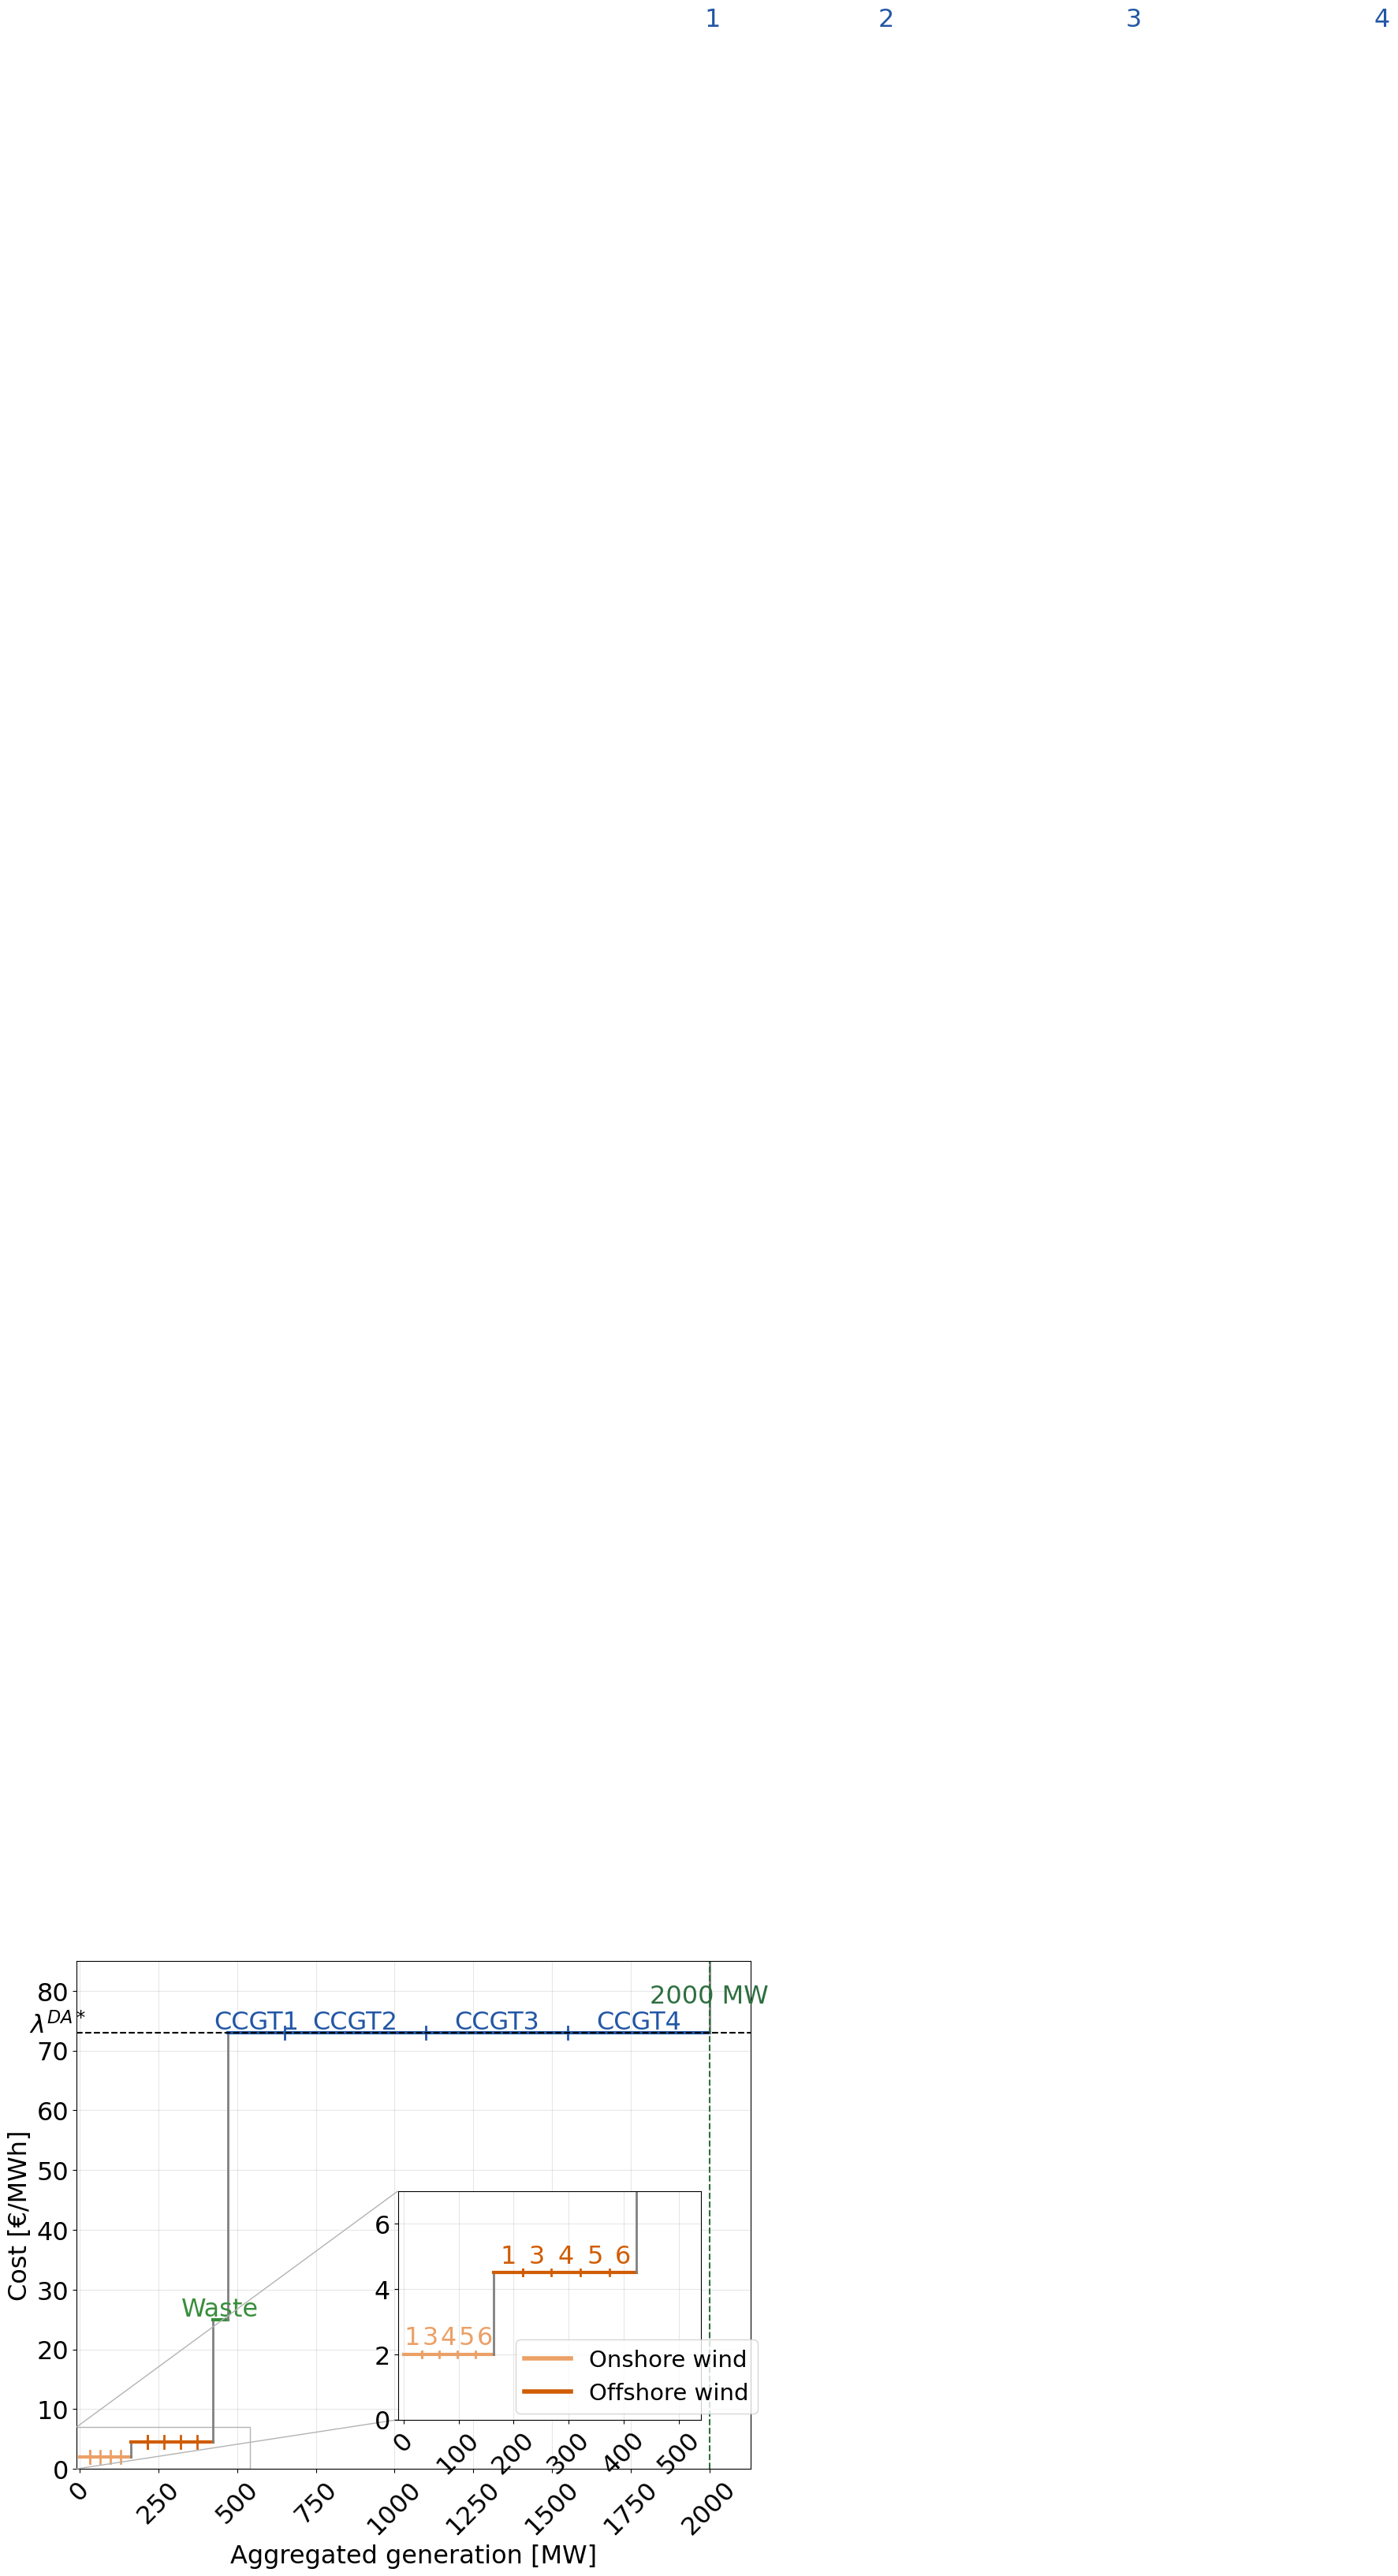

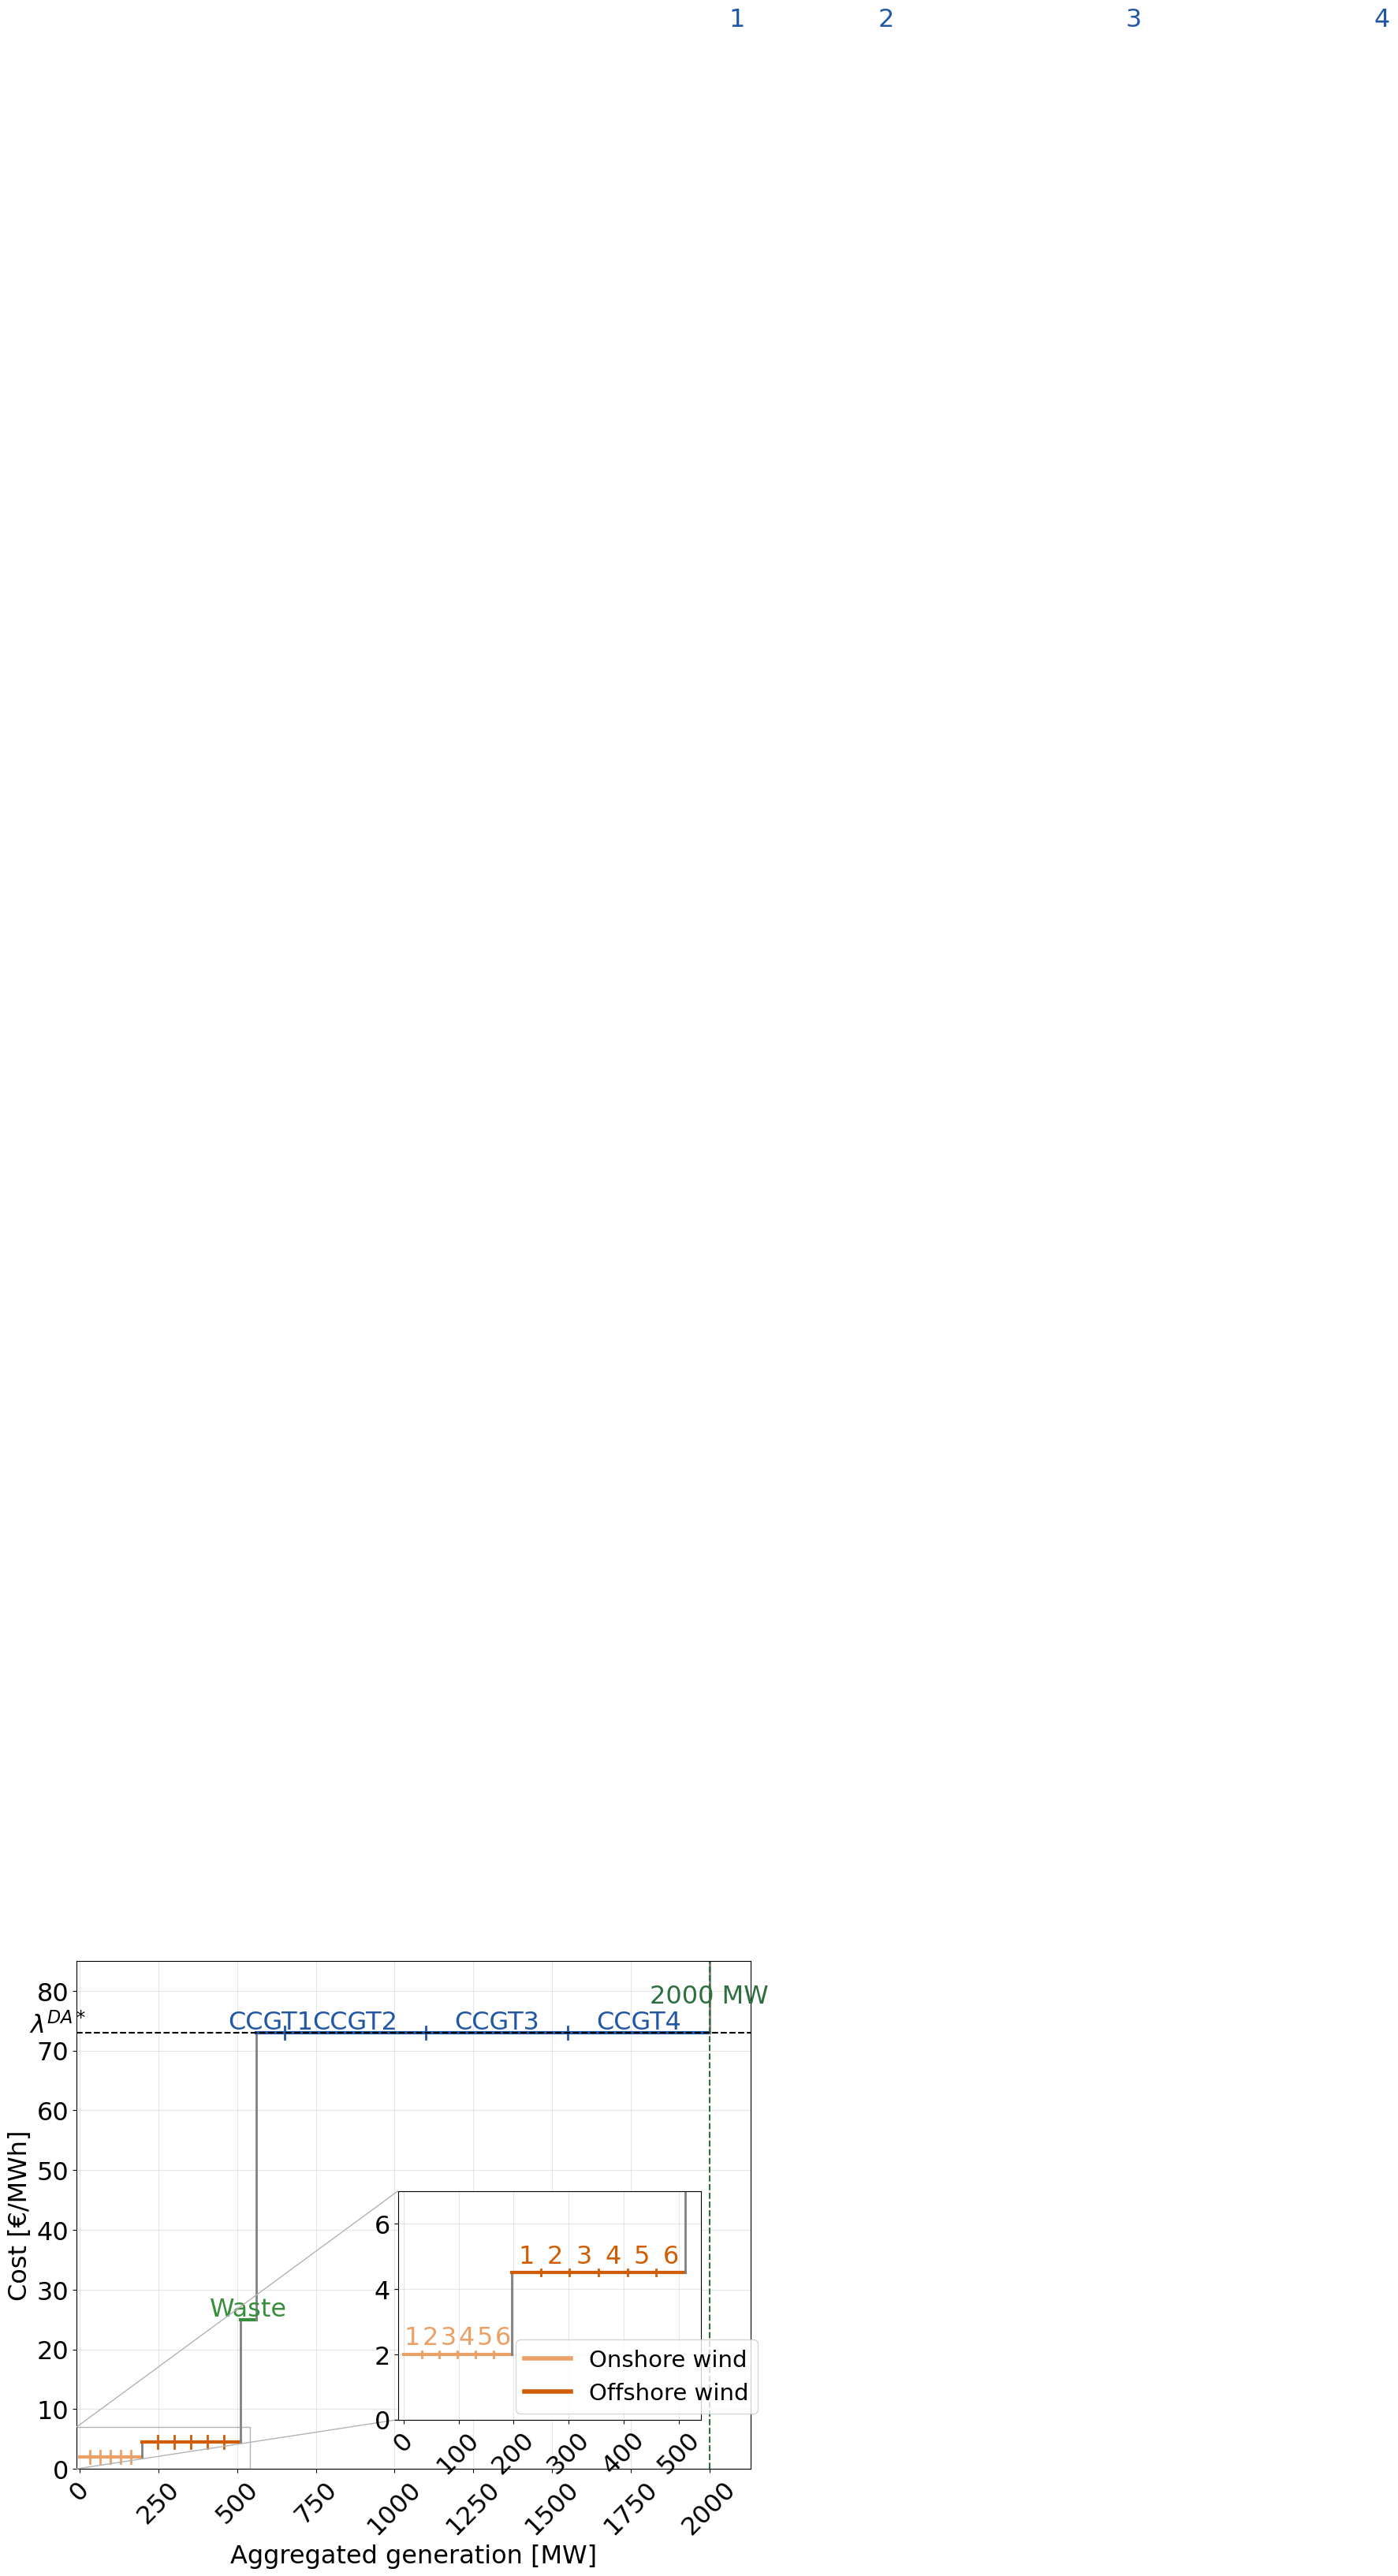

In [23]:
# DAY AHEAD
fold = 0  # Fold for DA MOC plot

Deviators = [f"On{i}" for i in range(1, 7)] + [ f"Off{i}" for i in range(1,7)] # Example names for 10 polluters

price, fig = pf.merit_order_price_DA(data_BM["bids"]["DA_bids_outsample"][fold],
                   Cp, Cf, Cr,
                   Deviators, Flexibles, Base_loads, title = "", fontsize=23)
#fig
plt.savefig(f"../Figures/Results/MOC/Merit_Order_Curve_DA_Fold{fold}_BM.pdf", dpi=300)

price, fig = pf.merit_order_price_DA(data_bin["bids"]["DA_bids_outsample"][fold],
                   Cp, Cf, Cr,
                   Deviators, Flexibles, Base_loads, title = "", fontsize=23)
#fig
plt.savefig(f"../Figures/Results/MOC/Merit_Order_Curve_DA_Fold{fold}_FCB.pdf", dpi=300)

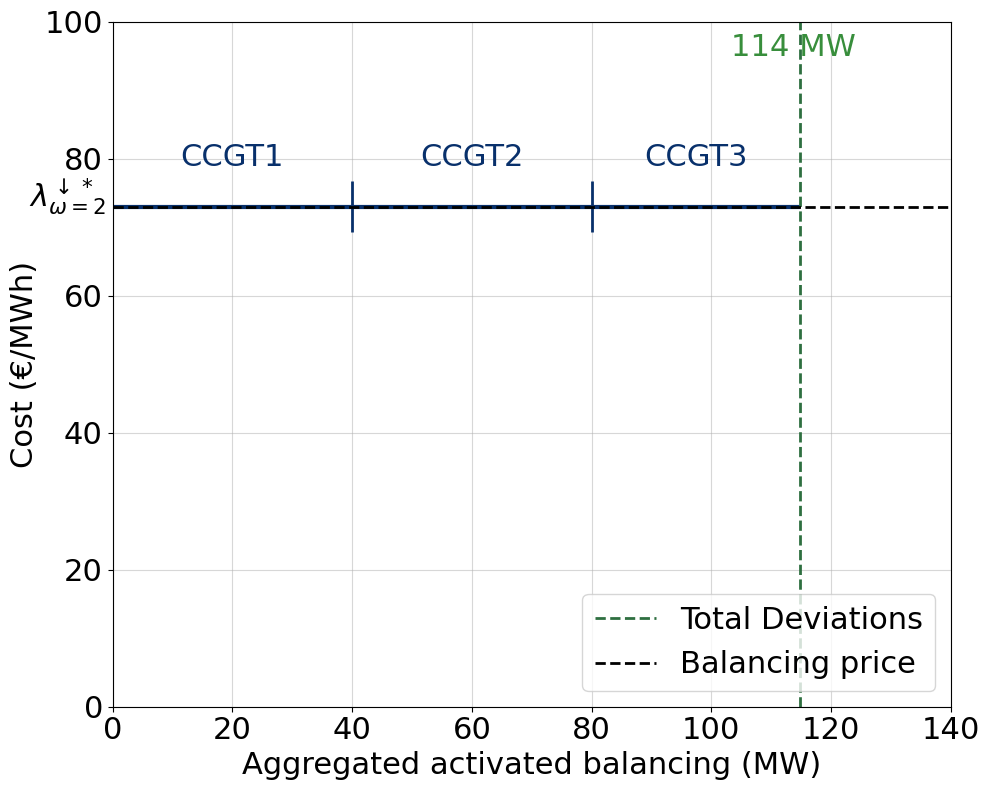

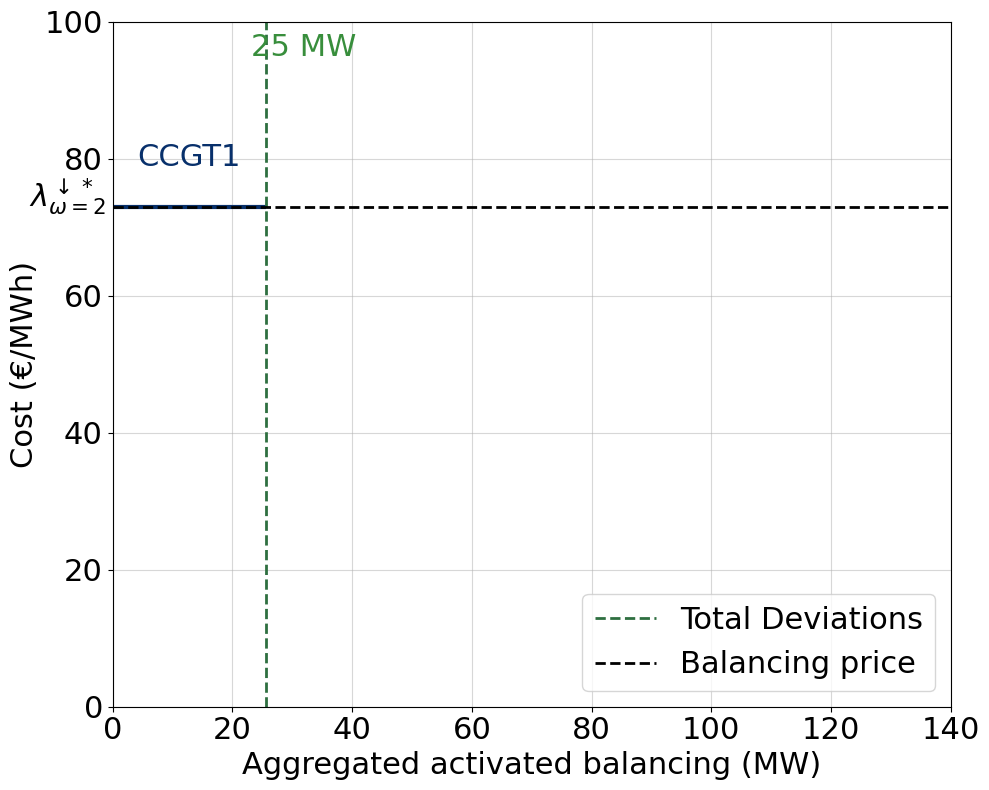

In [25]:
# BALANCING
fold = 0 # Fold for BM MOC plot and out of sample
nb_w = 1 # Scenario to plot

fig = pf.merit_order_price_balancing(
    data_BM["bids"]["DA_bids_outsample"][fold],
    data_BM["split_info"]["out_sample_Pw"][fold],
    nS=nS_out_sample,
    rf_up=rf_up,
    rf_down=rf_down,
    Cf=Cf,
    nF=len(Flexibles),
    nP=len(Deviators),
    nb_w=nb_w,
    figsize=(10,8),
    fontsize= 22)
#plt.show()
plt.savefig(f"../Figures/Results/MOC/MOC_balancing_foldf{fold+1}_sc{nb_w+1}_BM.pdf")

fig = pf.merit_order_price_balancing(
    data_bin["bids"]["DA_bids_outsample"][fold],
    data_bin["split_info"]["out_sample_Pw"][fold],
    nS=nS_out_sample,
    rf_up=rf_up,
    rf_down=rf_down,
    Cf=Cf,
    nF=len(Flexibles),
    nP=len(Deviators),
    nb_w=nb_w,
    figsize = (10, 8), 
    fontsize= 22)
#plt.show()
plt.savefig(f"../Figures/Results/MOC/MOC_balancing_foldf{fold+1}_sc{nb_w+1}_FCB.pdf")

System imbalance

In [26]:
system_imbalance_bin = data_bin["history"]["system_imbalance"]
system_imbalance_BM = data_BM["history"]["system_imbalance"]

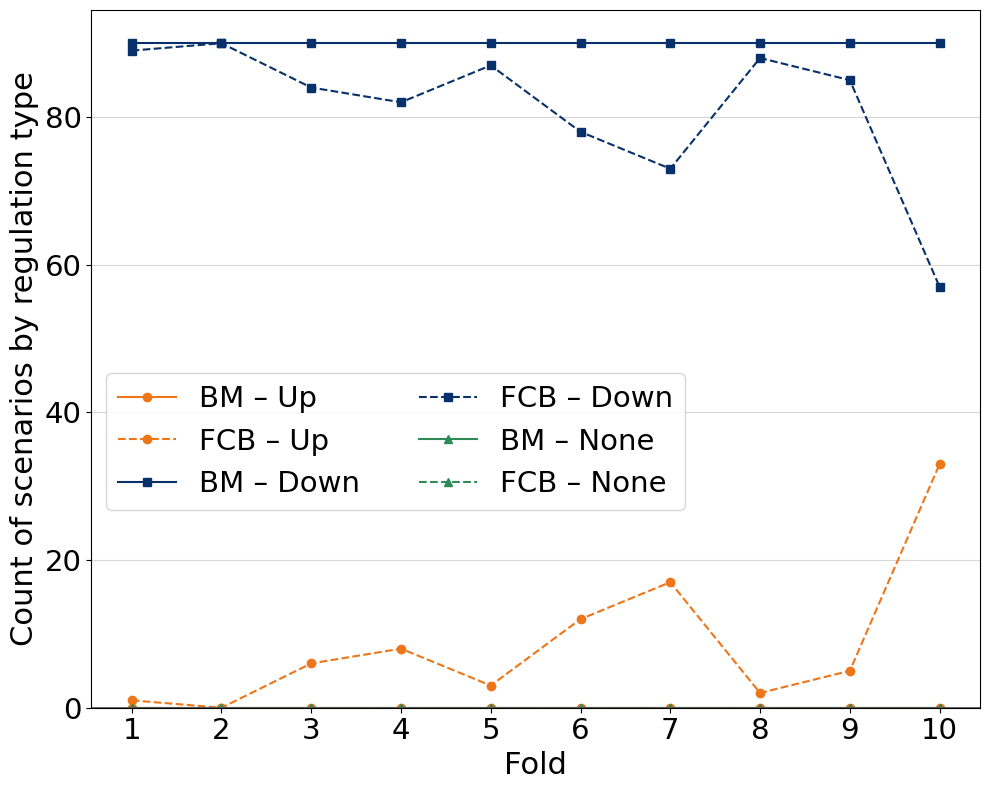

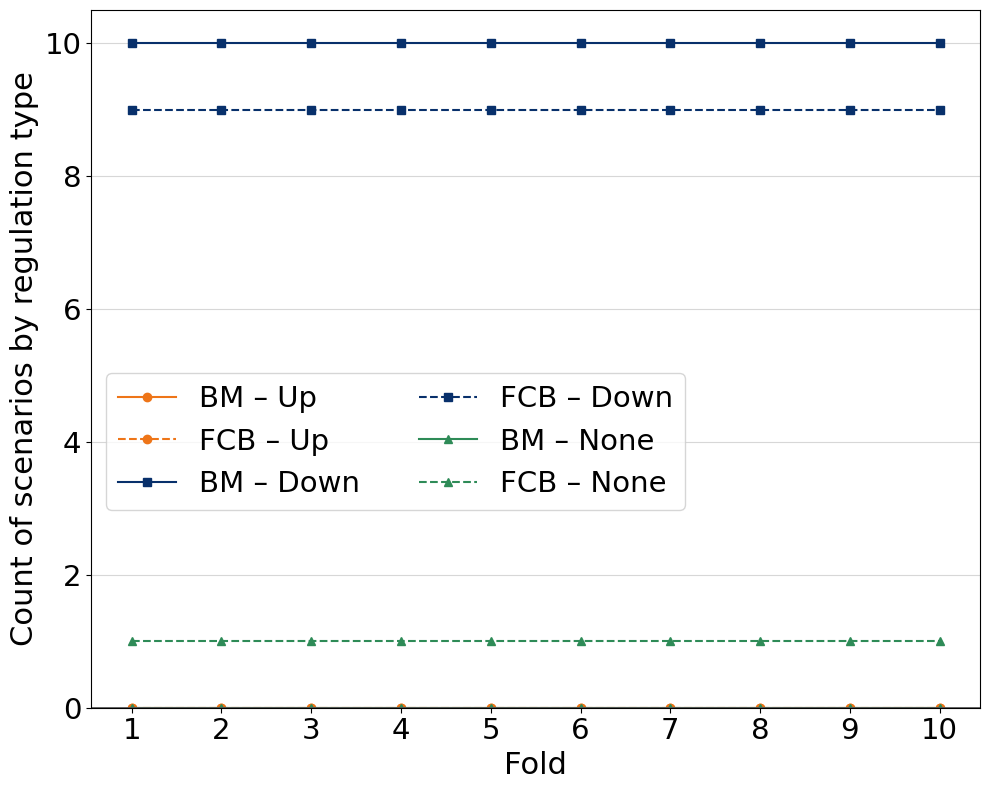

In [27]:
fig_out, fig_in = pf.plot_SI_in_out_BM_vs_BIN_one_axes(
    system_imbalance_BM=system_imbalance_BM,
    system_imbalance_BIN=system_imbalance_bin,
    component_names=("Up", "Down", "None"),
    tol=1e-6,   # use your tolerance
    legend_anchor=(0, 0.5), # as you requested
    legend_ncol=2,
    figsize = (10, 8),
    fontsize = 22
)

fig_out.savefig("../Figures/Results/scenario_count_reg_OUT.pdf", bbox_inches="tight")
fig_in.savefig("../Figures/Results/scenario_count_reg_IN.pdf", bbox_inches="tight")

In [40]:
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

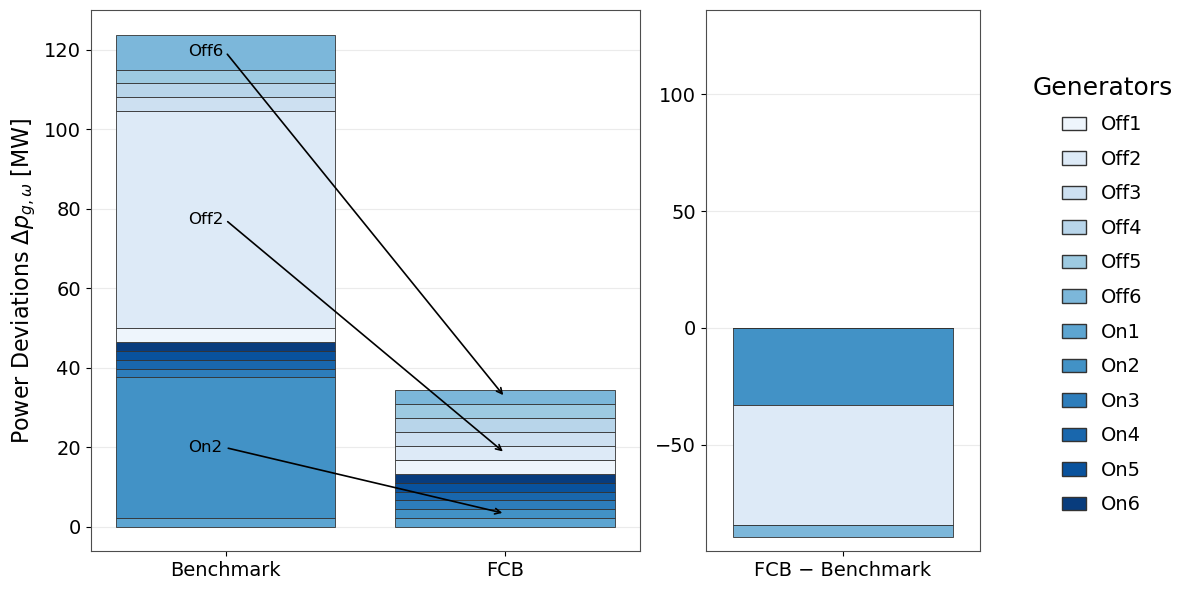

In [37]:
fig_dev = pf.plot_power_deviations_models(model_names, deviations_list, Deviators, base_color="Blues",
                            figsize=(10, 6),
                            # geometry
                            bar_width=0.55,
                            x_step=0.70,

                            # fonts
                            title_fontsize=20,
                            label_fontsize=16,
                            tick_fontsize=14,
                            legend_fontsize=14,
                            legend_title_fontsize=18,

                            # styling
                            grid_alpha=0.25,
                            separator_color="0.2",     # gray separators
                            separator_lw=0.6,
                            legend_title="Generators",)

fig_dev.savefig("../Figures/Results/power_deviations_and_difference.pdf", bbox_inches="tight")

['Onshore1', 'Onshore2', 'Onshore3', 'Onshore4', 'Onshore5', 'Onshore6', 'Offshore1', 'Offshore2', 'Offshore3', 'Offshore4', 'Offshore5', 'Offshore6']
['SCGT1', 'SCGT2', 'SCGT3', 'SCGT4', 'CCGT1', 'CCGT2', 'CCGT3', 'CCGT4']
['Biomass', 'Coal', 'Waste']


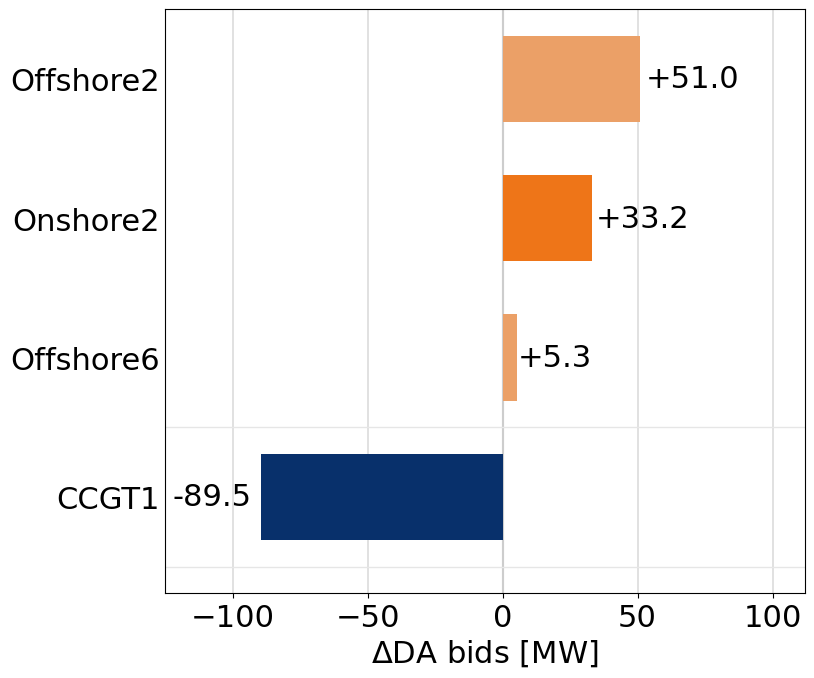

In [42]:
fig_diff = pf.plot_DA_bid_difference_one_color_from_nested_dict(
    DA_bids=DA_bids,
    generators_by_type=names_by_type,
    model_names=("Benchmark", "FCB"),
    tech_colors=tech_colors,
    sort_by="abs",
    title = "",
    gap_between_types=0,
    figsize=(10.0, 8.0),
    fontsize=22,
)

fig_diff.savefig("../Figures/Results/Difference_DA_bids.pdf")

In [59]:
#include python file plotting_functions.py 
import importlib, plotting_functions as pf
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

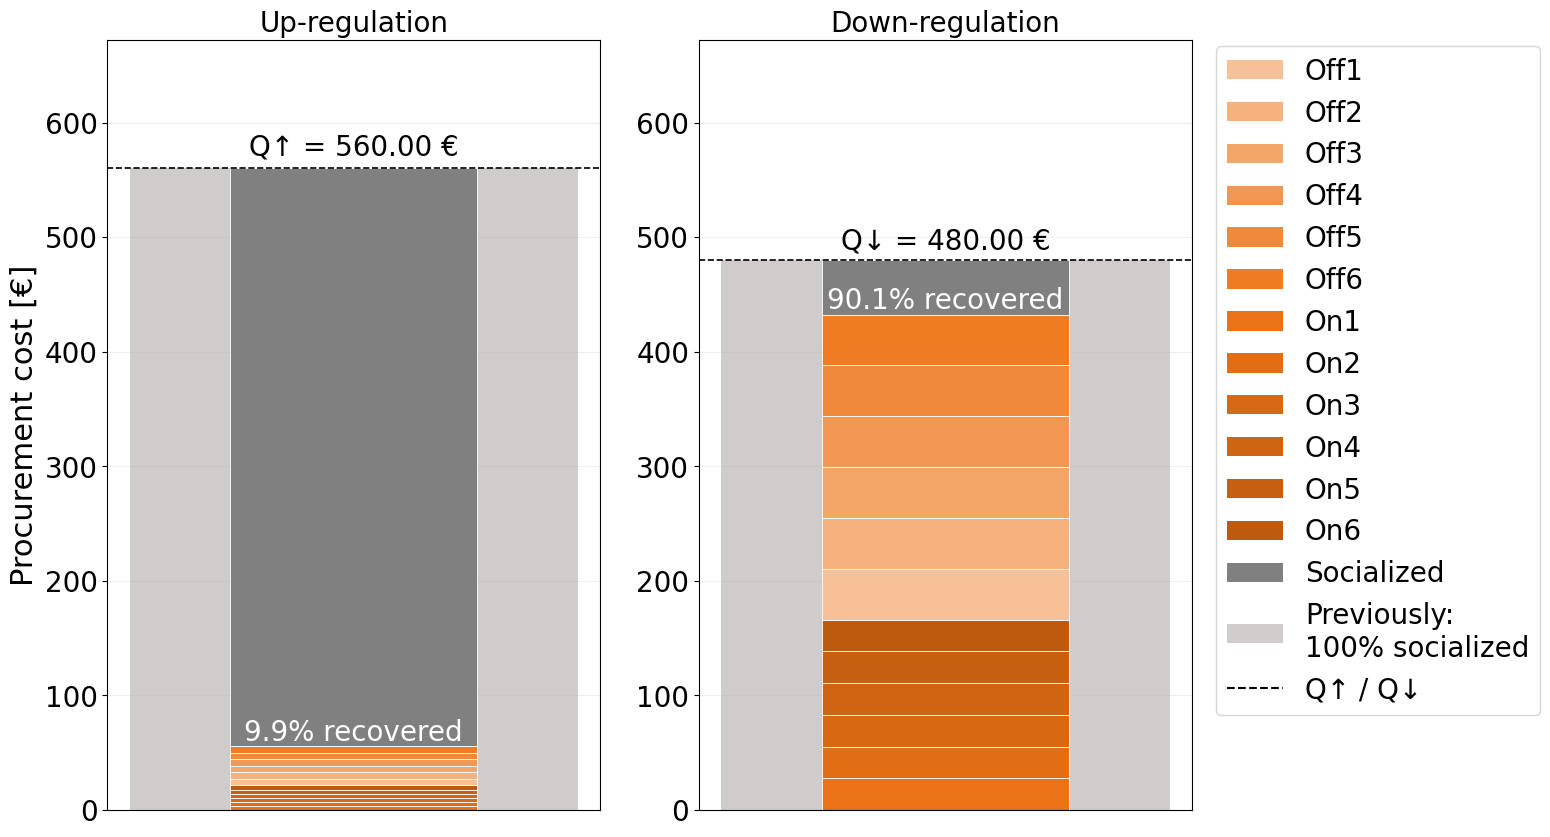

In [60]:
fig_socialized = pf.plot_socialized_vs_individualized_FCB_only(
    pBIN_fcb=pBIN_list[1],
    Q_up=Q_up_list[1],
    Q_down=Q_down_list[1],
    polluters=Deviators,
    anchors=("#F7C096", "#EE7518", "#BE5A0E"),  # your orange scheme
    color_order="sorted",  # optional: keep colors ordered by name in the legend
    figsize=(14, 10),
    prev_social_color="#d0cccc",
    fontsize = 20
)

fig_socialized.savefig("../Figures/Results/Socialized_penalty.pdf", bbox_inches="tight")

In [45]:
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

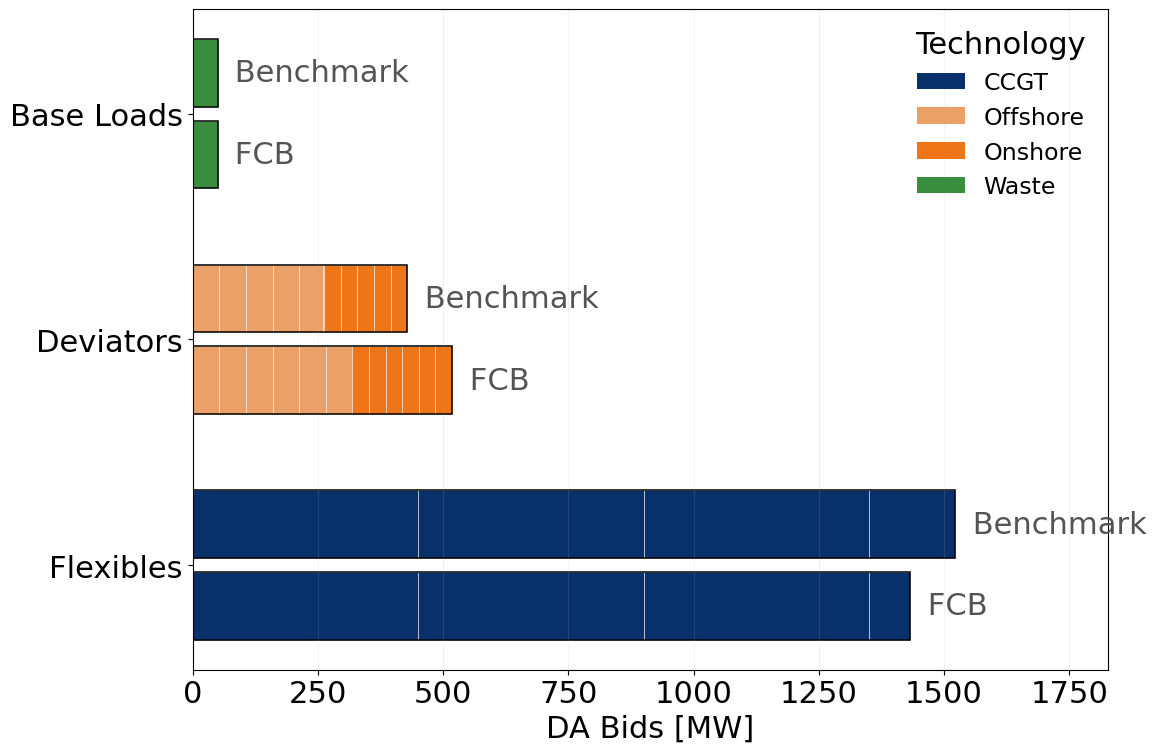

In [46]:
fig_DA_bids = pf.plot_DA_bids_transposed_models_by_type_generators(
    DA_bids,
    types_to_plot=["Deviators", "Flexibles", "Base loads"],
    names_by_type=names_by_type,
    tech_colors=tech_colors,
    base_fontsize=22,
    tick_fontsize=22,
    legend_fontsize=22,
    figsize=(12, 8),
    sep_lw = 0.4,
    sep_color = "#f2f2f2"   # very light gray instead of white

)

fig_DA_bids.savefig("../Figures/Results/DA_bids.pdf")

Profits

0.0


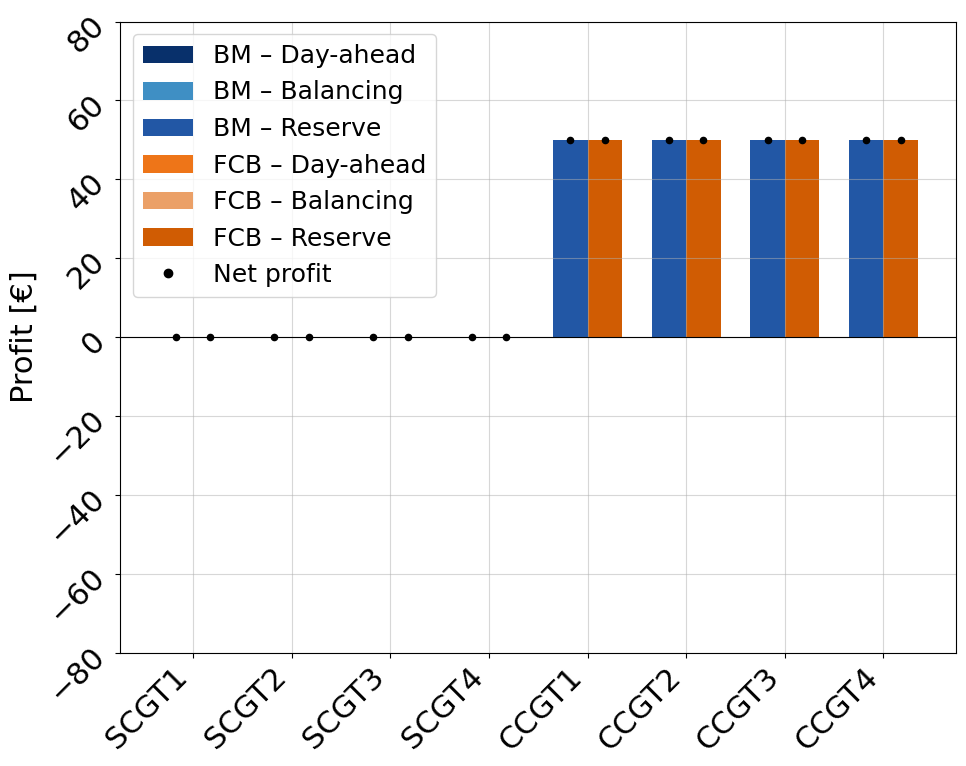

In [148]:
fig_pflex = pf.stacked_posneg_matrix(pBM_flex, pBIN_flex, Flexibles, markets_f, participant_type="Flexibles", ylim = (-80, 80), fontsize = 22)
fig_pflex.savefig("../Figures/Results/profits_flexible.pdf")

0.0


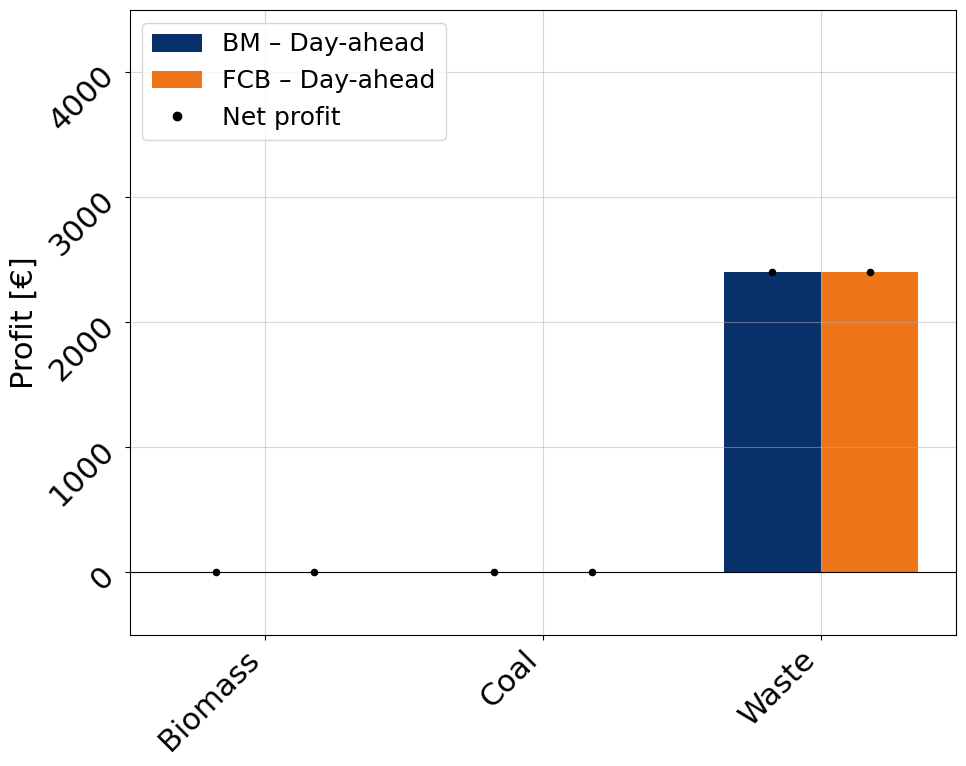

In [63]:
fig_pbase = pf.stacked_posneg_matrix(pBM_base, pBIN_base, Base_loads, markets_r, participant_type="Regular Generators", ylim = (-500, 4500), fontsize = 22)
fig_pbase.savefig("../Figures/Results/profits_base.pdf")

2480.9057648042944


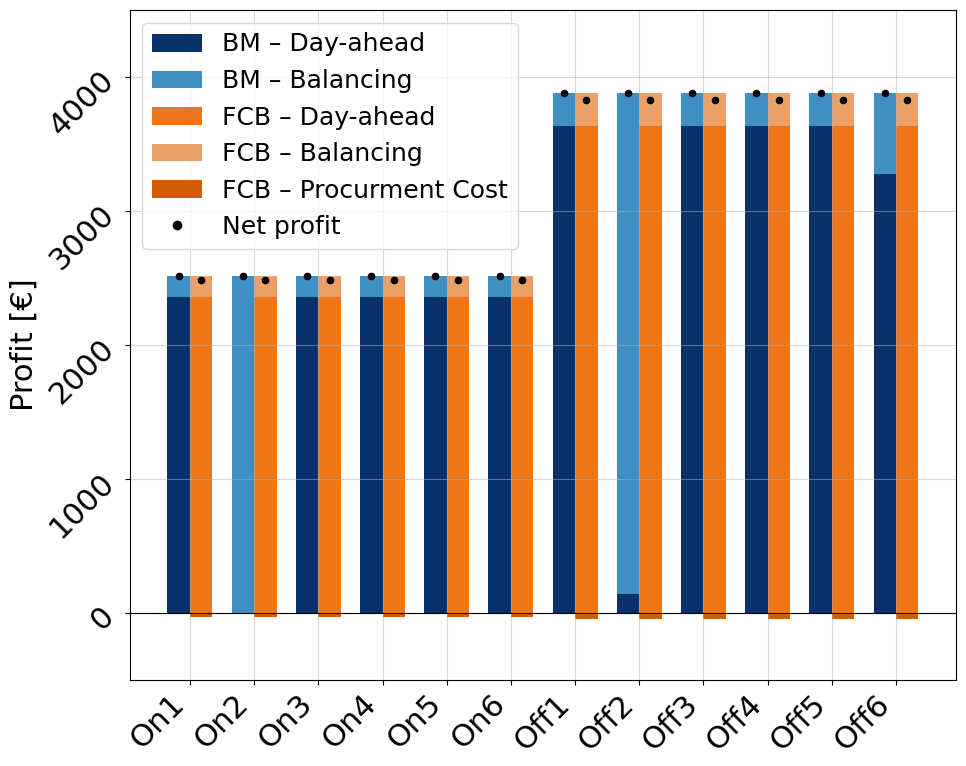

In [64]:
Deviators_short = [f"On{i}" for i in range(1, 7)] + [ f"Off{i}" for i in range(1,7)] # Example names for 10 polluters

fig_pdev = pf.stacked_posneg_matrix(pBM_dev, pBIN_dev, Deviators_short, markets_p, participant_type="Polluters", ylim = (-500, 4500), fontsize = 22)
fig_pdev.savefig("../Figures/Results/profits_deviators.pdf")

Profits per MWh

In [126]:
power_realized_d_outsample = np.zeros((10, nP))
power_realized_f_outsample = np.zeros((10, nF))
power_realized_r_outsample = np.zeros((10, nR))

for fold in range(10):
    power_realized_d_outsample[fold, :] = data_bin["bids"]["DA_bids_outsample"][fold][0] + data_bin["bids"]["B_pol_out"][:, fold]
    power_realized_f_outsample[fold, :] = data_bin["bids"]["DA_bids_outsample"][fold][1] - data_bin["bids"]["B_flex_down_out"][:, fold] + data_bin["bids"]["B_flex_up_out"][:, fold]
    power_realized_r_outsample[fold, :] = data_bin["bids"]["DA_bids_outsample"][fold][2]

mean_power_realized_d = np.mean(power_realized_d_outsample, axis=0)
mean_power_realized_f = np.mean(power_realized_f_outsample, axis=0)
mean_power_realized_r = np.mean(power_realized_r_outsample, axis=0)

In [143]:
pBM_dev_perMWh = pBM_dev/mean_power_realized_d[:, None]
pBIN_dev_perMWh = pBIN_dev/mean_power_realized_d[:, None]

pBM_flex_perMWh = pBM_flex/mean_power_realized_f[:, None]
pBIN_flex_perMWh = pBIN_flex/mean_power_realized_f[:, None]

pBM_base_perMWh = pBM_base/mean_power_realized_r[:, None]
pBIN_base_perMWh = pBIN_base/mean_power_realized_r[:, None]

C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\378101805.py:4: RuntimeWarning: invalid value encountered in divide
  pBM_flex_perMWh = pBM_flex/mean_power_realized_f[:, None]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\378101805.py:5: RuntimeWarning: invalid value encountered in divide
  pBIN_flex_perMWh = pBIN_flex/mean_power_realized_f[:, None]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\378101805.py:7: RuntimeWarning: invalid value encountered in divide
  pBM_base_perMWh = pBM_base/mean_power_realized_r[:, None]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\378101805.py:8: RuntimeWarning: invalid value encountered in divide
  pBIN_base_perMWh = pBIN_base/mean_power_realized_r[:, None]


In [159]:
pBIN_flex_perMWh

array([[       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [0.        , 0.        , 0.88616708],
       [0.        , 0.        , 0.11321529],
       [0.        , 0.        , 0.11111839],
       [0.        , 0.        , 0.11111111]])

Profits in sample vs outsample accross folds

In [66]:
profits_pol_in = data_bin["profits"]["pol_in"]
profits_pol_out = data_bin["profits"]["pol_out"]
profits_flex_in = data_bin["profits"]["flex_in"]
profits_flex_out = data_bin["profits"]["flex_out"]
profits_reg_in = data_bin["profits"]["reg_in"]
profits_reg_out = data_bin["profits"]["reg_out"]
# Added a check: only look at 'v' if it is a list or array


# Pass your matrix to Julia
Main.profits_matrix_in = profits_pol_in
Main.profits_matrix_out = profits_pol_out
Main.profits_flex_in = profits_flex_in
Main.profits_flex_out = profits_flex_out
Main.profits_reg_in = profits_reg_in
Main.profits_reg_out = profits_reg_out

# Map the sum function over the matrix
# 'v' is each cell. If it has length, we sum it; otherwise, we return v.
summed_matrix_in = Main.seval("""
    map(profits_matrix_in) do v
        v isa AbstractVector ? sum(v) : v
    end
""")

summed_matrix_out = Main.seval("""
    map(profits_matrix_out) do v
        v isa AbstractVector ? sum(v) : v
    end
""")


summed_flex_in = Main.seval("""
    map(profits_flex_in) do v
        v isa AbstractVector ? sum(v) : v
    end
""")

summed_flex_out = Main.seval("""
    map(profits_flex_out) do v
        v isa AbstractVector ? sum(v) : v
    end
""")

summed_reg_in = Main.seval("""
    map(profits_reg_in) do v
        v isa AbstractVector ? sum(v) : v
    end
""")

summed_reg_out = Main.seval("""
    map(profits_reg_out) do v
        v isa AbstractVector ? sum(v) : v
    end
""")


summed_profits_pol_in = np.array(summed_matrix_in)
summed_profits_pol_out = np.array(summed_matrix_out)

summed_profits_flex_in = np.array(summed_flex_in)
summed_profits_flex_out = np.array(summed_flex_out) 
summed_profits_reg_in = np.array(summed_reg_in)
summed_profits_reg_out = np.array(summed_reg_out)

In [122]:
def get_Pw_stats(pw_data, prob):

    # 2. Convert to a 3D Numpy array: shape (10 scenarios, rows, columns)
    # We use a list comprehension to ensure each Julia matrix is converted correctly
    arr = np.array([np.array(m) for m in pw_data])
    prob = np.array([np.array(m) for m in prob])
    
    nS = arr.shape[1]  # Number of scenarios (should be 10)

    # Onshore min, max, mean and std for the first element (onshore 1) across all 10 scenarios
    min_on= np.min(arr[:, :, 0], axis=1)
    max_on = np.max(arr[:, :, 0], axis=1)
    mean_on = np.round(np.sum(prob[:, w]*arr[:, w, 0] for w in range(nS)), 2)
    std_on = np.round(np.std(arr[:, :, 0], axis=1), 2)

    # Offshore min, max, mean and std for the last element (offshore 6) across all 10 scenarios
    min_off = np.min(arr[:, :, -1], axis=1)
    max_off = np.max(arr[:, :, -1], axis=1)
    mean_off = np.round(np.sum(prob[:, w]*arr[:, w, -1] for w in range(nS)), 2)
    std_off = np.round(np.std(arr[:, :, -1], axis=1), 2)

    diff_off = max_off - min_off
    diff_on = max_on - min_on
    return diff_on, diff_off, mean_on, std_on, mean_off, std_off

diff_on_in, diff_off_in, mean_on_in, std_on_in, mean_off_in, std_off_in = get_Pw_stats(data_bin["split_info"]["in_sample_Pw"], data_bin["split_info"]["in_sample_prob"])
diff_on_out, diff_off_out, mean_on_out, std_on_out, mean_off_out, std_off_out = get_Pw_stats(data_bin["split_info"]["out_sample_Pw"], data_bin["split_info"]["out_sample_prob"])

C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\1368099771.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  mean_on = np.round(np.sum(prob[:, w]*arr[:, w, 0] for w in range(nS)), 2)
C:\Users\Gloria\AppData\Local\Temp\ipykernel_42216\1368099771.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  mean_off = np.round(np.sum(prob[:, w]*arr[:, w, -1] for w in range(nS)), 2)


In [113]:
DA_bids_all_folds_dev = {} 
B_bids_all_folds_dev = {} 
DA_bids_all_folds_dev_in = {} 
B_bids_all_folds_dev_in = {}
DA_bids_all_folds_dev_diff = {} 
B_bids_all_folds_dev_diff = {}
for i in range(10): 
    DA_bids_all_folds_dev[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["DA_bids_outsample"][i][0], 
        "FCB": data_bin["bids"]["DA_bids_outsample"][i][0], } 
    B_bids_all_folds_dev[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["B_pol_out"][:,i], 
        "FCB": data_bin["bids"]["B_pol_out"][:,i], } 
    DA_bids_all_folds_dev_in[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["DA_bids_insample"][i][0], 
        "FCB": data_bin["bids"]["DA_bids_insample"][i][0], } 
    B_bids_all_folds_dev_in[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["B_pol_in"][:,i], 
        "FCB": data_bin["bids"]["B_pol_in"][:,i], } 
    
    DA_bids_all_folds_dev_diff[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["DA_bids_insample"][i][0] - data_BM["bids"]["DA_bids_outsample"][i][0], 
        "FCB": data_bin["bids"]["DA_bids_insample"][i][0] - data_bin["bids"]["DA_bids_outsample"][i][0], } 
    
    B_bids_all_folds_dev_diff[f"Fold_{i+1}"] = { 
        "Benchmark": data_BM["bids"]["B_pol_in"][:,i] - data_BM["bids"]["B_pol_out"][:,i], 
        "FCB": data_bin["bids"]["B_pol_in"][:,i] - data_bin["bids"]["B_pol_out"][:,i], } 
    
pol_out_bids = { "DA_bids": DA_bids_all_folds_dev, "B_bids": B_bids_all_folds_dev }
pol_in_bids= { "DA_bids": DA_bids_all_folds_dev_in, "B_bids": B_bids_all_folds_dev_in }
pol_diff_bids= { "DA_bids": DA_bids_all_folds_dev_diff, "B_bids": B_bids_all_folds_dev_diff }


In [114]:
means = [mean_on_in, mean_off_in, mean_on_out, mean_off_out]
stds = [std_on_in, std_off_in, std_on_out, std_off_out]
profits = [summed_profits_pol_in, summed_profits_pol_out, summed_profits_flex_in, summed_profits_flex_out, summed_profits_reg_in, summed_profits_reg_out]

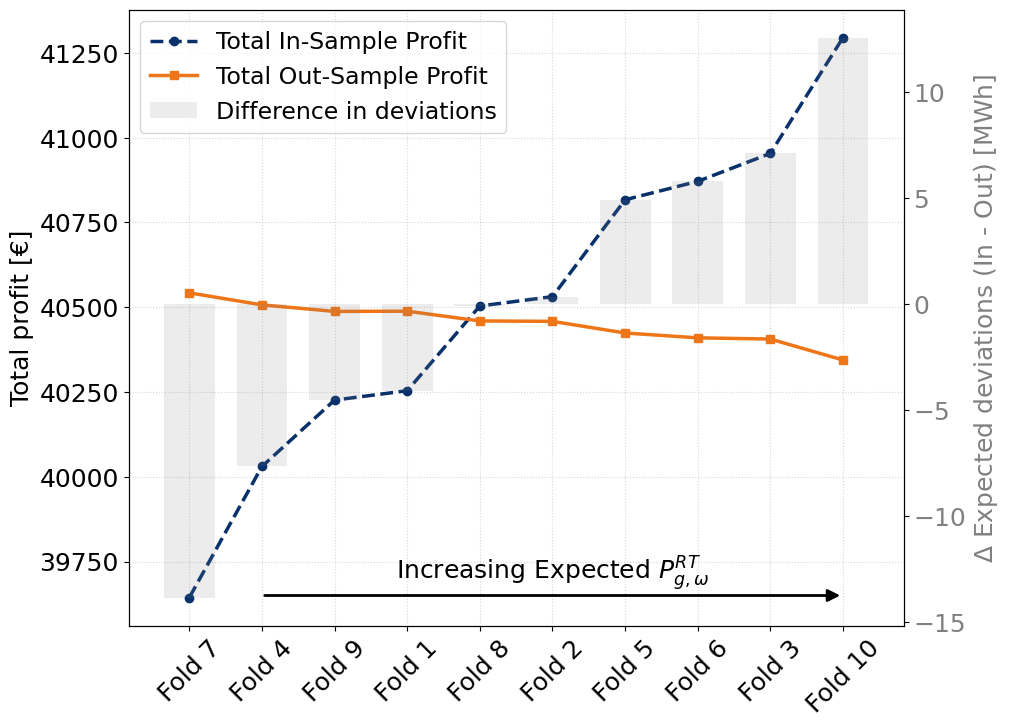

In [115]:
fig_profits_folds = pf.profits_across_folds(means, stds, profits, B_bids_all_folds_dev_diff)
fig_profits_folds.savefig("../Figures/Results/fig_profits_vs_folds.pdf", dpi=300)

Onshore1 DA avg: 33.18 MW (std: 0.52)
Onshore1 B  avg: 2.20 MW (std: 0.54)
Offshore1 DA avg: 53.09 MW (std: 0.83)
Offshore1 B  avg: 3.52 MW (std: 0.86)


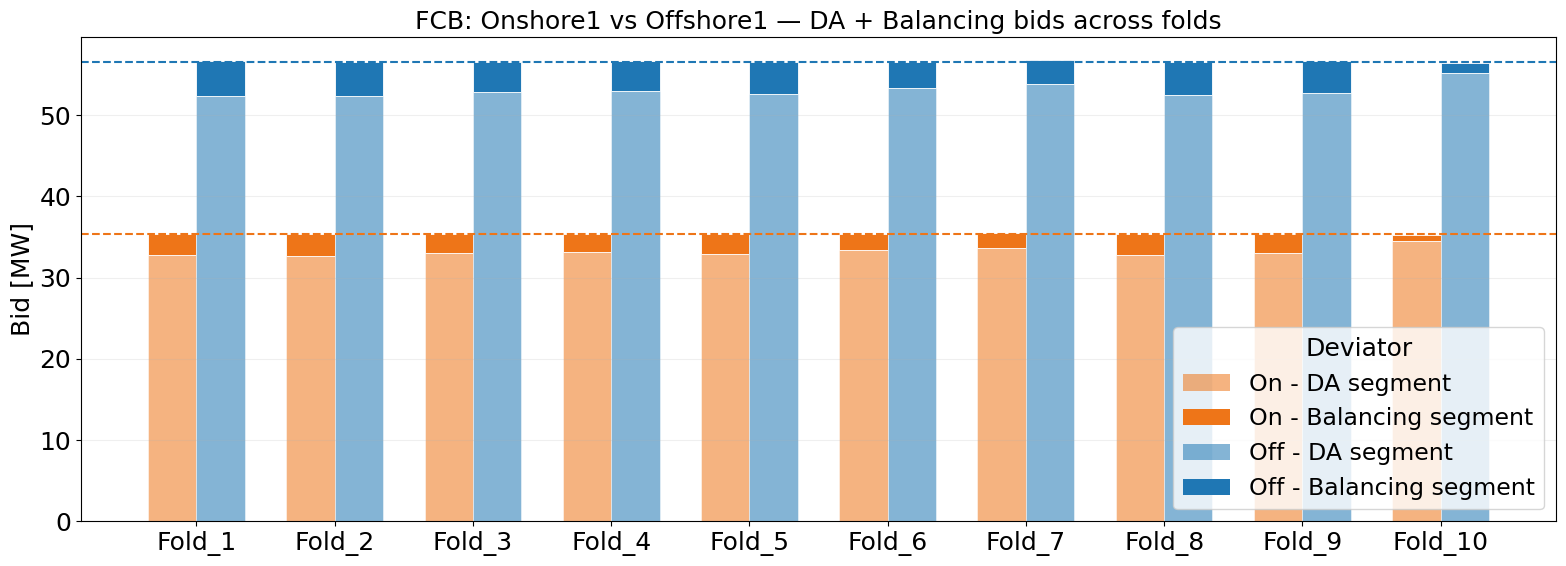

Onshore1 DA avg: 33.18 MW (std: 0.52)
Onshore1 B  avg: 2.20 MW (std: 0.57)
Offshore1 DA avg: 53.09 MW (std: 0.83)
Offshore1 B  avg: 3.52 MW (std: 0.90)


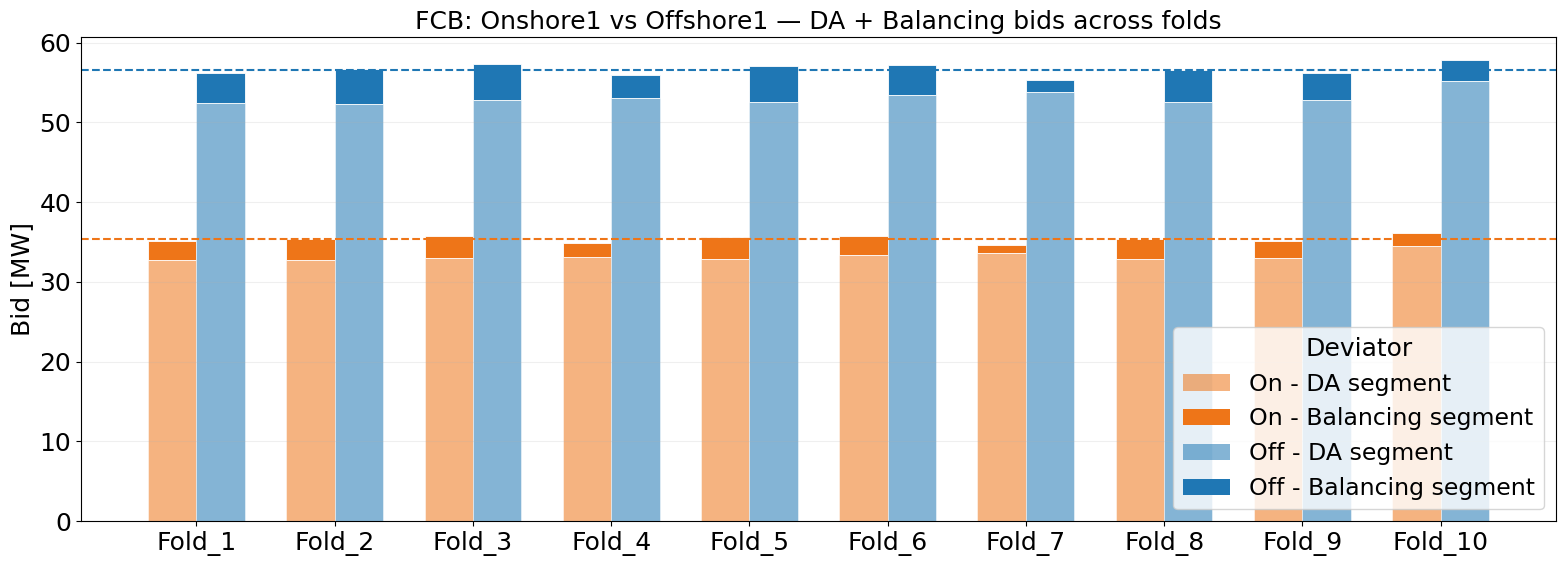

In [ ]:
pf.plot_all_folds_two_deviators_FCB_DAplusB(
    pol_out_bids=pol_out_bids,
    deviator_names=Deviators,
    onshore_idx=0,
    offshore_idx=6,
    model="FCB",
    figsize=(16, 6),
    title="FCB: Onshore1 vs Offshore1 — DA + Balancing bids across folds",
    DA=True
)


pf.plot_all_folds_two_deviators_FCB_DAplusB(
    pol_out_bids=pol_in_bids,
    deviator_names=Deviators,
    onshore_idx=0,
    offshore_idx=6,
    model="FCB",
    figsize=(16, 6),
    title="FCB: Onshore1 vs Offshore1 — DA + Balancing bids across folds",
    DA=True
)

System's cost

In [ ]:
def costs_per_fold(fold, nS, nP, nF, nR, prob_all, DA_bids, B_bids_pol, B_pol_expected, 
                   B_bids_flex, R_bids, Cf_Rup, Cf_Rdown, Q_up=None, Q_down=None, tol=1e-6):
    # This is for 1 fold
    # B_bids corresponds to the up [0] and down [0] bids that are contributing to the system imbalance
    pol_cost = [None] * nP
    flex_cost = [None] * nF
    reg_cost = [None] * nR

    include_penalty = Q_up is not None and Q_down is not None
    prob = prob_all[fold]
    
    k_up = np.zeros((nS, nP))
    k_down = np.zeros((nS, nP))

    # --- imbalance shares ---
    for w in range(nS):
        total_imbalance = np.sum(B_bids_pol[fold][0][w, :]) + np.sum(B_bids_pol[fold][1][w, :]) # SUM OF UP AND DOWN REGULATION DEVIATIONS FOR THIS SCENARIO
        z_down = np.sum(B_bids_pol[fold][1][w, :]) # DOWN REGULATION
        z_up = np.sum(B_bids_pol[fold][0][w, :])  # UP REGULATION

        for p in range(nP):
            bid_up = B_bids_pol[fold][0][w, p]
            bid_down = B_bids_pol[fold][1][w, p]

            if total_imbalance > tol and bid_down > 0:
                k_down[w, p] = bid_down / z_down
            elif total_imbalance < -tol and bid_up < 0:
                k_up[w, p] = bid_up / z_up

    # --- polluters ---
    for p in range(nP):
        cost_DA = DA_bids[fold][0][p] * Cp[p]
        cost_B = Cp[p]*B_pol_expected[p, fold]
        penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
        penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0

        pol_cost[p] = [cost_DA, cost_B, penalty_up, penalty_down]


    # --- flexible units ---
    for f in range(nF):
        cost_DA = DA_bids[fold][1][f] * Cf[f]
        cost_B = Cf[f] * (B_bids_flex[0][f, fold] - B_bids_flex[1][f, fold])               # IT SHOULD BE FIRST UP [0] THEN  DOWN [0] BUT THE VALUES ARE SWAPPED FOR NOW
        cost_R = (
            R_bids[0][f] * Cf_Rup[f]
            + R_bids[1][f] * Cf_Rdown[f])
        cost_R = 0
        flex_cost[f] = [cost_DA, cost_B, cost_R]

    # --- regular generators ---
    for r in range(nR):
        cost_DA = DA_bids[fold][2][r] * Cr[r]
        reg_cost[r] = [cost_DA]

    return pol_cost, flex_cost, reg_cost


In [ ]:
systems_costs_BM_in = []
systems_costs_BM_out = []
systems_costs_FCB_in =[]
systems_costs_FCB_out =[]

prob_insample = data_BM["split_info"]["in_sample_prob"]
prob_outsample = data_BM["split_info"]["out_sample_prob"]

for fold in range (10):
    flex_bids_insample = [data_BM["bids"]["B_flex_up_in"], data_BM["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_BM["bids"]["DA_bids_insample"], data_BM["bids"]["B_bids_all_insample"], data_BM["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=None, Q_down=None, tol=1e-6)
    systems_costs_BM_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_BM["bids"]["B_flex_up_out"], data_BM["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_BM["bids"]["DA_bids_outsample"], data_BM["bids"]["B_bids_all_outsample"], data_BM["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=None, Q_down=None, tol=1e-6)
    systems_costs_BM_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_insample = [data_bin["bids"]["B_flex_up_in"], data_bin["bids"]["B_flex_down_in"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_in_sample, nP, nF, nR, prob_insample, data_bin["bids"]["DA_bids_insample"], data_bin["bids"]["B_bids_all_insample"], data_bin["bids"]["B_pol_in"], flex_bids_insample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_FCB_in.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

    flex_bids_outsample = [data_bin["bids"]["B_flex_up_out"], data_bin["bids"]["B_flex_down_out"]]
    pol_cost, flex_cost, reg_cost = costs_per_fold(fold, nS_out_sample, nP, nF, nR, prob_outsample, data_bin["bids"]["DA_bids_outsample"], data_bin["bids"]["B_bids_all_outsample"], data_bin["bids"]["B_pol_out"], flex_bids_outsample, R_bids, Cf_Rup, Cf_Rdown, Q_up=q_up, Q_down=q_down, tol=1e-6)
    systems_costs_FCB_out.append({"pol": pol_cost, "flex": flex_cost, "reg": reg_cost})

C:\Users\Gloria\AppData\Local\Temp\ipykernel_30836\1696805136.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_up = np.sum(prob[w] * Q_up * k_up[w, p] for w in range(nS)) if include_penalty else 0.0
C:\Users\Gloria\AppData\Local\Temp\ipykernel_30836\1696805136.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  penalty_down = np.sum(prob[w] * Q_down * k_down[w, p] for w in range(nS)) if include_penalty else 0.0


In [ ]:
data_bin["bids"]["DA_bids_insample"][0][0]

12-element Vector{Float64}:
 32.76
 32.76
 32.76
 32.76
 32.760000000000154
 32.76
 52.42
 52.42
 52.42
 52.42
 52.42
 52.42

In [ ]:
data_bin["bids"]["DA_bids_insample"][6][0]

12-element Vector{Float64}:
 33.64
 33.63999999999987
 33.64
 33.64
 33.64
 33.64000000000009
 53.8199999999993
 53.82
 53.82
 53.82
 53.82
 53.82

In [ ]:
data_bin["bids"]["DA_bids_insample"][9][0]

12-element Vector{Float64}:
 34.51
 34.51
 34.51
 34.51
 34.51
 34.51
 55.22
 55.22
 55.21999999999992
 55.22
 55.22
 55.22

In [ ]:
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Gloria\\Github\\Full-cost-balancing-\\Code\\plotting_functions.py'>

total diff in :  430.67364658154804
total diff out:  487.94461229567133
penalty down in insample 430.67364658154804
penalty down in outsample 432.332326225972
penalty up in outsample 55.61228606969924
total diff penalty:  487.9446122956712
systems costs difference in outsample in % 0.4635633148687231
TOtal systems cost in FCB out 105747.24100007885


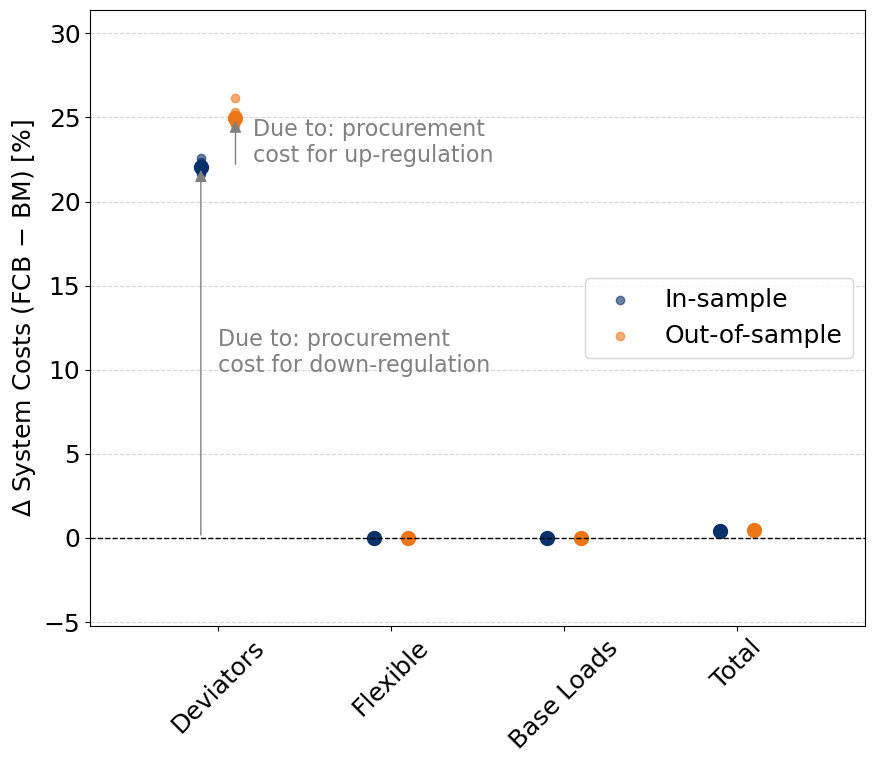

In [ ]:
fig_systems_costs = pf.systems_costs(systems_costs_BM_in, systems_costs_BM_out, systems_costs_FCB_in, systems_costs_FCB_out)
fig_systems_costs.savefig("../Figures/Results/diff_in_costs.pdf", bbox_inches='tight')

c:\Users\Gloria\anaconda3\envs\integrated-energy-grids\Lib\site-packages\brokenaxes.py:344: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  result.append(getattr(ax, method)(*args, **kwargs))
c:\Users\Gloria\anaconda3\envs\integrated-energy-grids\Lib\site-packages\brokenaxes.py:344: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  result.append(getattr(ax, method)(*args, **kwargs))
c:\Users\Gloria\anaconda3\envs\integrated-energy-grids\Lib\site-packages\brokenaxes.py:344: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  result.append(getattr(ax, method)(*args, **kwargs))
c:\Users\Gloria\anaconda3\envs\integrated-energy-grids\Lib\site-packages\brokenaxes.py:344: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

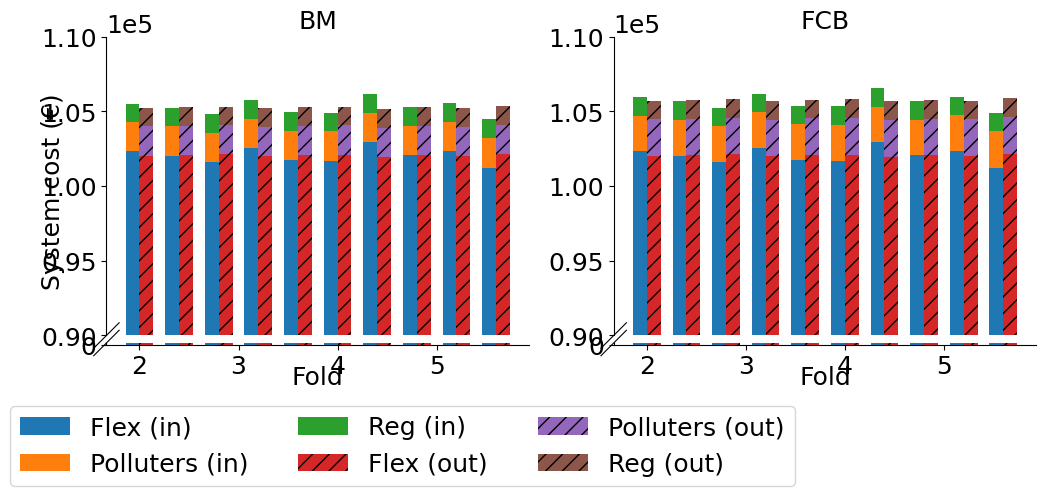

In [ ]:
from matplotlib.gridspec import GridSpec
from brokenaxes import brokenaxes

BM_in  = pf.split_costs(systems_costs_BM_in)
BM_out = pf.split_costs(systems_costs_BM_out)
FCB_in  = pf.split_costs(systems_costs_FCB_in)
FCB_out = pf.split_costs(systems_costs_FCB_out)

x = np.arange(10)
width = 0.35

# Create figure and GridSpec with 1 row, 2 cols
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure=fig)

# Create brokenaxes using the GridSpec
bax1 = brokenaxes(ylims=((0, 100), (90000, 110000)), hspace=0.05, subplot_spec=gs[0])
bax2 = brokenaxes(ylims=((0, 100), (90000, 110000)), hspace=0.05, subplot_spec=gs[1])

def stacked_broken(bax, IN, OUT, title):
    # Flexibles at the bottom
    bax.bar(x - width/2, IN[1], width, label="Flex (in)")
    bax.bar(x - width/2, IN[0], width, bottom=IN[1], label="Polluters (in)")
    bax.bar(x - width/2, IN[2], width, bottom=IN[1]+IN[0], label="Reg (in)")

    bax.bar(x + width/2, OUT[1], width, bottom=0, hatch="//", label="Flex (out)")
    bax.bar(x + width/2, OUT[0], width, bottom=OUT[1], hatch="//", label="Polluters (out)")
    bax.bar(x + width/2, OUT[2], width, bottom=OUT[1]+OUT[0], hatch="//", label="Reg (out)")

    bax.set_title(title)
    bax.set_xlabel("Fold")
    bax.set_xticks(x)
    bax.set_xticklabels(range(1, 11))
    bax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Plot the two broken axes
stacked_broken(bax1, BM_in, BM_out, "BM")
stacked_broken(bax2, FCB_in, FCB_out, "FCB")

# Add legends (only once is enough)
bax2.legend(ncol=3, fontsize=18, loc='lower center', bbox_to_anchor = (-0.5, -0.5))
bax1.set_ylabel("System cost (€)")

plt.show()

In [ ]:
profits_pol_in = data_bin["profits"]["pol_in"]
profits_pol_out = data_bin["profits"]["pol_out"]
# Added a check: only look at 'v' if it is a list or array

# Pass your matrix to Julia
Main.profits_matrix_in = profits_pol_in
Main.profits_matrix_out = profits_pol_out

# Map the sum function over the matrix
# 'v' is each cell. If it has length, we sum it; otherwise, we return v.
summed_matrix_in = Main.eval("""
    map(profits_matrix_in) do v
        v isa AbstractVector ? sum(v) : v
    end
""")

summed_matrix_out = Main.eval("""
    map(profits_matrix_out) do v
        v isa AbstractVector ? sum(v) : v
    end
""")


summed_profits_pol_in = np.array(summed_matrix_in)
summed_profits_pol_out = np.array(summed_matrix_out)


In [ ]:
pw_data = data_bin["split_info"]["in_sample_Pw"]

# 2. Convert to a 3D Numpy array: shape (10 scenarios, rows, columns)
# We use a list comprehension to ensure each Julia matrix is converted correctly
arr = np.array([np.array(m) for m in pw_data])

# 3. Calculate Min and Max for the 1st element (column 0) across all 10 folds
min_start = np.min(arr[:, :, 0], axis=0)
print(min_start)
max_start = np.max(arr[:, :, 0], axis=0)
print(max_start)

# 4. Calculate Min and Max for the last element (column -1) across all 10 scenarios
min_end = np.min(arr[:, :, -1], axis=0)
print(min_end)
max_end = np.max(arr[:, :, -1], axis=0)
print(max_end)
diff_off = max_end - min_end
diff_on = max_start - min_start

print("Difference ON (last - first) min:", diff_on)
print("Difference ON (last - first) max:", diff_off)
print("Difference OFF (first - last) min:", diff_on*1.6)




[32.71 32.76 33.53 32.87 32.82 33.26 33.04 33.15 32.93 33.09]
[38.12 37.68 37.19 37.85 37.96 36.81 37.79 38.07 37.46 37.35]
[52.33 52.42 53.65 52.6  52.51 53.21 52.86 53.03 52.68 52.95]
[60.99 60.29 59.51 60.55 60.73 58.89 60.47 60.9  59.94 59.77]
Difference ON (last - first) min: [5.41 4.92 3.66 4.98 5.14 3.55 4.75 4.92 4.53 4.26]
Difference ON (last - first) max: [8.66 7.87 5.86 7.95 8.22 5.68 7.61 7.87 7.26 6.82]
Difference OFF (first - last) min: [8.656 7.872 5.856 7.968 8.224 5.68  7.6   7.872 7.248 6.816]


mmm, the difference for offshore is 1.6 greater than onshore, which makes sens, since that's what we set it up to be. 

So, there is no rule according to which the results do well or bad actually. For the 3 lowest differences, the profit insample is much higher than outsample, which makes sense, because there is more deviations in the out-sample group then. But, later on I can't say there is a rule to it. 

In [ ]:
# 1. Extract Penalty Up (3rd element in Julia)
Main.profits_matrix_in = profits_pol_in
penalty_up_in = Main.eval("""
    map(profits_matrix_in) do v
        # If v is a vector [p1, p2, p3, p4], grab index 3
        (v isa AbstractVector && length(v) >= 3) ? v[3] : 0.0
    end
""")

# 2. Extract Penalty Down (4th element in Julia)
penalty_down_in = Main.eval("""
    map(profits_matrix_in) do v
        (v isa AbstractVector && length(v) >= 4) ? v[4] : 0.0
    end
""")

# Repeat for Out-Sample
Main.profits_matrix_out = profits_pol_out
penalty_up_out = Main.eval("map(v -> (v isa AbstractVector && length(v) >= 3) ? v[3] : 0.0, profits_matrix_out)")
penalty_down_out = Main.eval("map(v -> (v isa AbstractVector && length(v) >= 4) ? v[4] : 0.0, profits_matrix_out)")

# Plot for Up-Regulation (3rd element in Julia vectors)
p_up = pf.plot_penalty_violins(penalty_up_in, penalty_up_out, title_suffix="Up-Regulation")

# Plot for Down-Regulation (4th element in Julia vectors)
p_down = pf.plot_penalty_violins(penalty_down_in, penalty_down_out, title_suffix="Down-Regulation")

TypeError: plot_penalty_violins() missing 1 required positional argument: 'Deviators'

penalty(fold and polluter) - like it used to be 

In [ ]:
data_BM["aggregates"]["mean_pol_DA_bids_out"]

12×1 Matrix{Float64}:
 33.184
  0.0
 33.184
 33.184
 33.184
 33.184
 53.093999999999994
  2.0640000000000045
 53.093999999999994
 53.093999999999994
 53.093999999999994
 47.83200000000001

In [ ]:
data_BM["bids"]["DA_bids_outsample"][9]

3-element Vector{Vector{Float64}}:
 [34.51, 0.0, 34.51, 34.51, 34.51, 34.51, 55.22, 0.0, 55.22, 55.22, 55.22, 41.230000000000004]
 [0.0, 0.0, 0.0, 0.0, 165.33999999999992, 450.0, 450.0, 450.0]
 [0.0, 0.0, 50.0]